# Хакатон "Analytics, Design and PM" с Мастерской Яндекс.Практикума

## Содержание

1) [Описание проекта](#anchor_1)  
2) [Изучение данных](#anchor_2)  
3) [Изучение аномалий](#anchor_3)  
4) [Преобразование и объединение таблиц](#anchor_4)  
5) [Проблемы студентов](#anchor_5)  
6) [Портреты пользователей](#anchor_6)  
7) [Сегментирование студентов. Кластеризация. Гипотезы по улучшению выстраивания помощи студентам в достижении их целей.](#anchor_7)  
8) [Общий вывод по исследованию](#anchor_8) 

<a id='anchor_1'></a>
## Описание проекта
Создание и оформление отчёта целей обучения студентов
Яндекс Практикума для презентации топ-менеджменту Яндекс
Практикума.

**Цель исследования**

Совершенствование программы помощи студентам в достижении их целей.

**Задачи исследования**

● определить нормальные и найти аномальные показатели  
● определить коррелирующие параметры, построить портреты студентов,  
сравнить их, чтобы выделить значимые закономерности  
● сегментировать студентов (по 2м и более показателям), выявить  
особенности сегментов  
● сформулировать на основе данных гипотезы по улучшению   
выстраивания помощи студентам в достижении их целей,  
● оформить выводы и гипотезы аналитиков с помощью инструментов  
фигмы для презентации руководству Яндекс Практикума.  

**Описание данных**

Таблица data_goals_answers:
* question_title — текст вопроса
* question_type — тип вопроса
* user_id — уникальный id пользователя
* user_answer — ответ пользователя на вопрос
* answer_date — время ответа
* answer_id — id ответа
* cohort, current_cohort — начальная и текущая когорта студента
* course_name, topic_name, lesson_name — курс, тема и урок, на котором студент отвечает на вопрос
   У нас значения должны быть Трудоустройство-Трудоустройство-Цель обучения, т.к. мы изучаем именно это
* original_segment, current_segment — b2c/b2b/b2g — из какого сегмента был/стал студент — сам является клиентом, его обучение оплачивается бизнесом или государством
* profession_name — код профессии
* statement_content — формулировка вопроса об уверенности в знаниях (в этой таблице нету)
* slide_position — страница опроса (не нужно для анализа)

Таблица hackathon_metrics:
* profession_name — код профессии
* user_id — уникальный id пользователя
* lp_avg_user — средний learning performance  
   Первые, более высокие значения в таблице с фри-трека, последние с курса, наиболее актуально находящееся в таблице ниже
* question_title — текст вопроса
* user_answer — ответ пользователя на вопрос
* statement_content — формулировка вопроса об уверенности в знаниях 
* value — ответ на вопрос об уверенности в знаниях для расчёта learning experience индекса

**Ход исследования:**

1) Изучение данных. Вывод основной информации.  
2) Изучение аномалий, устранение ошибок.  
3) Преобразование и объединение таблиц.  
4) Проблемы студентов. Визуализация метрик.  
5) Формирование портретов пользователей. Сравнение метрик по группам в контексте бинарной классификации целей.  
6) Сегментирование студентов. Матрица корреляций. Построение модели кластеризации пользователей. Гипотезы по улучшению выстраивания помощи студентам в достижении их целей.  
7) Общий вывод по исследованию.

<a id='anchor_2'></a>
## Изучение данных
Произведем импорт необходимых библитек. Прочитаем данные и посмотрим первые строки:

In [1]:
# импорт основных библиотек
import pandas as pd
import numpy as np

# импорт библиотек для визуализации
import seaborn as sns
import matplotlib.pyplot as plt

# настройки отображения
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

# импорт библиотек для кластеризации и построения моделей
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
import itertools
from scipy.cluster.hierarchy import dendrogram, linkage 
from scipy import stats 

# импорт библиотеки для игнорирования предупреждений
import warnings
warnings.filterwarnings("ignore")

Прочитаем данные и выведем 5 первых строк:

In [2]:
dga = pd.read_excel('data_goals_answers_fin.xlsx')
dga.head(1)

,Unnamed: 0,user_id,answer_date,answer_id,cohort,course_name,current_cohort,current_segment,lesson_name,original_segment,profession_name,question_title,question_type,slide_position,statement_content,topic_name,user_answer
0,1,3157,2023-09-01 10:43:00,41ac1a75-1f3b-44bd-a2f2-346c3bdef7b3,data_cohort_121,Трудоустройство,data_cohort_121,b2g,Цель обучения,b2g,data-analyst,"Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.",checkbox,0,NaN,Трудоустройство,определение профессиональной сферы


In [3]:
hm = pd.read_csv('hackathon_metrics.csv')
hm.head(1)

,Unnamed: 0,profession_name,user_id,lp_avg_user,statement_content,value,question_title,user_answer
0,0,sql-data-analyst,14641026,0.86,Моя уверенность в своих знаниях значительно повысилась по сравнению с предыдущим спринтом,2,"Какова вероятность, что вы порекомендуете Практикум своим друзьям по шкале от 0 до 10, где 10 — обязательно порекомендую, 0 — не порекомендую ни за что?",9.00


Напишем функцию для вывода основной информации, проверим наличие дубликатов и пропусков, рассчитаем количество уникальных пользователей:

In [4]:
# Функция для вывода основной информации 
def df_info(df):
    print('Общая информация:')
    df.info()
    print()
    print('Пропуски в относительном выражении (%):')
    display(df.isna().sum()/len(df)*100)
    print()
    print('Случайная выборка по данным:')
    display(df.sample(n=5, random_state=1))
    print()
    print('Первичная статистика по данным:')
    display(df.describe().T)
    print()
    print('Количество уникальных пользователей:')
    display(df['user_id'].nunique())
    print()
    print('Количество полных дубликатов:',sum(df.duplicated()))

In [5]:
print('\n\033[2;30;47m Для таблицы с ответами пользователей : \033[0;0m')
print()
df_info(dga)


 Для таблицы с ответами пользователей : 

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43428 entries, 0 to 43427
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         43428 non-null  int64  
 1   user_id            43428 non-null  int64  
 2   answer_date        43428 non-null  object 
 3   answer_id          43428 non-null  object 
 4   cohort             43428 non-null  object 
 5   course_name        43428 non-null  object 
 6   current_cohort     43428 non-null  object 
 7   current_segment    43223 non-null  object 
 8   lesson_name        43428 non-null  object 
 9   original_segment   43223 non-null  object 
 10  profession_name    43428 non-null  object 
 11  question_title     43428 non-null  object 
 12  question_type      43428 non-null  object 
 13  slide_position     43428 non-null  int64  
 14  statement_content  0 non-null      float64
 15  topic_nam

Unnamed: 0            0.00
user_id               0.00
answer_date           0.00
answer_id             0.00
cohort                0.00
course_name           0.00
current_cohort        0.00
current_segment       0.47
lesson_name           0.00
original_segment      0.47
profession_name       0.00
question_title        0.00
question_type         0.00
slide_position        0.00
statement_content   100.00
topic_name            0.00
user_answer           0.03
dtype: float64


Случайная выборка по данным:


,Unnamed: 0,user_id,answer_date,answer_id,cohort,course_name,current_cohort,current_segment,lesson_name,original_segment,profession_name,question_title,question_type,slide_position,statement_content,topic_name,user_answer
39848,39849,15143579,2023-08-21 14:02:00,d9be1f2c-501f-482e-9658-83d6445fdb7c,data_cohort_121,Трудоустройство,data_cohort_121,b2g,Цель обучения,b2g,data-analyst,"Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.",checkbox,0,NaN,Трудоустройство,решение тестовых заданий
19099,19100,12653957,2023-08-16 11:26:00,c4a6d116-579e-4781-bfb2-fc98dba08a25,data_cohort_103,Трудоустройство,data_cohort_103,b2c,Цель обучения,b2c,data-analyst,Возможно вы нашли работу за время обучения?,radio,0,NaN,Трудоустройство,Нет
17899,17900,11995560,2023-08-29 21:50:00,584d7d3c-9097-44fa-a826-b51f6830a401,data_cohort_121,Трудоустройство,data_cohort_121,b2g,Цель обучения,b2g,data-analyst,"Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.",checkbox,0,NaN,Трудоустройство,резюме
30437,30438,14666372,2023-08-17 10:22:00,8cca5d67-a541-4123-ad89-99d0b4e331a3,data_cohort_119,Трудоустройство,data_cohort_121,b2g,Цель обучения,b2g,data-analyst,"Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.",checkbox,0,NaN,Трудоустройство,"не думаю, что вы можете мне с чем-то помочь"
6309,6310,1334239,2023-09-27 19:43:00,f6b0e56c-7990-446a-adb1-56cc94ebc8b4,data_cohort_125,Трудоустройство,data_cohort_125,b2g,Цель обучения,b2g,data-analyst,"Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.",checkbox,0,NaN,Трудоустройство,оформление портфолио



Первичная статистика по данным:


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,43428.00,21714.50,12536.73,1.00,10857.75,21714.50,32571.25,43428.00
user_id,43428.00,9978201.81,5839796.32,3157.00,3168334.00,13738151.00,14805767.00,16535210.00
slide_position,43428.00,0.16,0.37,0.00,0.00,0.00,0.00,1.00
statement_content,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Количество уникальных пользователей:


3549


Количество полных дубликатов: 0


Таблица перегружена лишними столбцами, ненужными с исследовании. Избавимся от них:

In [6]:
dga = dga.drop(columns={'slide_position'})
dga.columns

Index(['Unnamed: 0', 'user_id', 'answer_date', 'answer_id', 'cohort',
       'course_name', 'current_cohort', 'current_segment', 'lesson_name',
       'original_segment', 'profession_name', 'question_title',
       'question_type', 'statement_content', 'topic_name', 'user_answer'],
      dtype='object')

Перейдём к таблице с метриками хакатона:

In [7]:
print('\n\033[2;30;47m Для таблицы с метриками хакатона : \033[0;0m')
print()
df_info(hm)


 Для таблицы с метриками хакатона : 

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79117 entries, 0 to 79116
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         79117 non-null  int64  
 1   profession_name    79117 non-null  object 
 2   user_id            79117 non-null  int64  
 3   lp_avg_user        79117 non-null  float64
 4   statement_content  79117 non-null  object 
 5   value              79117 non-null  int64  
 6   question_title     14739 non-null  object 
 7   user_answer        14739 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 4.8+ MB

Пропуски в относительном выражении (%):


Unnamed: 0           0.00
profession_name      0.00
user_id              0.00
lp_avg_user          0.00
statement_content    0.00
value                0.00
question_title      81.37
user_answer         81.37
dtype: float64


Случайная выборка по данным:


,Unnamed: 0,profession_name,user_id,lp_avg_user,statement_content,value,question_title,user_answer
60686,60686,data-analyst,7400729,0.55,Моя уверенность в своих знаниях значительно повысилась по сравнению с предыдущим спринтом,2,NaN,NaN
71034,71034,data-scientist,15005991,0.74,Моя уверенность в своих знаниях значительно повысилась по сравнению с предыдущим спринтом,0,NaN,NaN
47954,47954,data-analyst,4183772,0.78,Моя уверенность в своих знаниях значительно повысилась по сравнению с предыдущим спринтом,0,NaN,NaN
55790,55790,data-analyst,14224540,0.90,Моя уверенность в своих знаниях значительно повысилась по сравнению с предыдущим спринтом,1,NaN,NaN
6098,6098,data-scientist,14293292,0.66,Моя уверенность в своих знаниях значительно повысилась по сравнению с предыдущим спринтом,2,NaN,NaN



Первичная статистика по данным:


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,79117.00,39558.00,22839.25,0.00,19779.00,39558.00,59337.00,79116.00
user_id,79117.00,10184950.73,5894170.39,377.00,3354706.00,13957325.00,14973640.00,16130827.00
lp_avg_user,79117.00,0.72,0.13,0.14,0.63,0.73,0.81,0.98
value,79117.00,0.92,1.07,-2.00,0.00,1.00,2.00,2.00
user_answer,14739.00,8.07,2.25,0.00,7.00,9.00,10.00,10.00



Количество уникальных пользователей:


9797


Количество полных дубликатов: 0


Данная таблица содержит значимые метрики для нашего исследования. Однако, lp_avg_user — средний learning performance рассчитывается постепенно с прогрессом студентов в рамках курса (с прохождением спринтов). Рекомендовано считать более точным значение данного показателя в записях, которые расположены ниже в таблице.  
Таким образом, для дальнейшего исследования необходимо таблицу преобразовать.

 <a id='anchor_3'></a>
## Изучение аномалий
Одной из задач исследования является определение нормальных и обнаружение аномальных показателей.

Вернемся к таблице с ответами:

In [8]:
dga.sample(1)

,Unnamed: 0,user_id,answer_date,answer_id,cohort,course_name,current_cohort,current_segment,lesson_name,original_segment,profession_name,question_title,question_type,statement_content,topic_name,user_answer
1124,1125,137526,2023-08-07 14:18:00,916d9158-c1c6-4795-b141-bc2b4a6bd988,ds_cohort_103,Трудоустройство,ds_cohort_103,b2c,Цель обучения,b2c,data-scientist,"Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.",checkbox,NaN,Трудоустройство,устройство рынка труда


Посмотрим на период исследования:

In [9]:
print('Период исследования:')
display(dga['answer_date'].min())
display(dga['answer_date'].max())

Период исследования:


'2023-07-05 20:31:00'

'2023-09-28 11:48:00'

Можно заметить, что в датасете представлены даты, ещё не наступившие. Данный столбец сгенерирован автоматически, чтобы деперсонализировать данные, и большой ценности в данном исследовании не несёт.  
Проверим, нет ли ошибок в названии курса, урока или темы, а также посмотрим из каких учебных направлений произведена выгрузка данных:

In [10]:
dga['course_name'].unique()

array(['Трудоустройство'], dtype=object)

In [11]:
dga['lesson_name'].unique()

array(['Цель обучения'], dtype=object)

In [12]:
dga['profession_name'].unique()

array(['data-analyst', 'data-scientist', 'data-analyst-plus',
       'systems-analyst', 'data-scientist-plus', 'sql-data-analyst',
       'data-engineer', 'datavis-and-bi-tools', 'data-science-bootcamp',
       'math-for-da-ds', 'data-analyst-bootcamp'], dtype=object)

In [13]:
dga['topic_name'].unique()

array(['Трудоустройство'], dtype=object)

Итак, ошибок в названиях нет. Представленными оказались данные об ответах студентов 11 программ: 
- data-analyst,
- data-analyst-plus,
- sql-data-analyst,
- data-analyst-bootcamp,
- data-scientist,
- data-scientist-plus,
- data-science-bootcamp,
- math-for-da-ds,
- systems-analyst,
- data-engineer,
- datavis-and-bi-tools.

Посмотрим, сколько ответов давали пользователи на вопросы, проверим найдутся ли здесь аномалии:

,user_id,answer_id
0,3157,12
1,5415,11
2,8199,10
3,8215,17
4,10202,11
5,11636,17
6,13862,17
7,13983,10
8,15700,11
9,16053,9


1

32

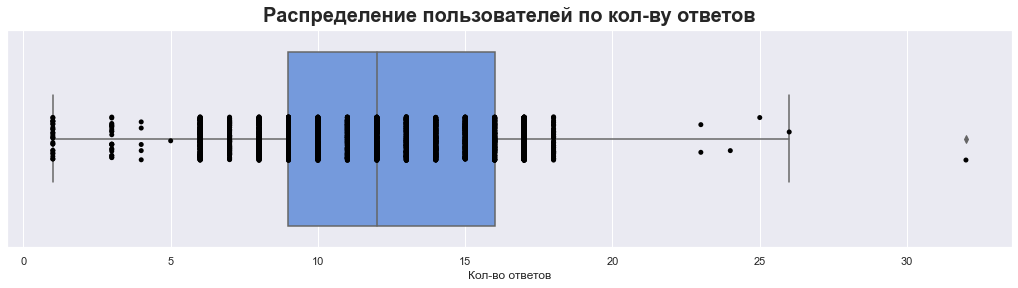

In [14]:
#Распределение ответов по пользователям 
user_ans_freq = dga.groupby('user_id', as_index=False)['answer_id'].count()
display(user_ans_freq.head(10))
display(user_ans_freq['answer_id'].min())
display(user_ans_freq['answer_id'].max())

plt.figure(figsize=(18,4))
sns.set_theme(style='darkgrid')
sns.boxplot(data=user_ans_freq['answer_id'], orient='h',color='cornflowerblue')
sns.stripplot(x = "answer_id",
              color = 'black',
              size = 5,
              alpha = 1,
              data = user_ans_freq)
plt.title("Распределение пользователей по кол-ву ответов",fontweight ="bold", fontsize='20', y=1.01)
plt.yticks([1], [''])
plt.xlabel("Кол-во ответов")
plt.show()

В среднем пользователи давали 10-15 ответов, но были и такие юзеры, которые дали более 30 ответов. Посмотрим, с чем это связано:

In [15]:
user_ans_freq.loc[user_ans_freq['answer_id'] > 30]

,user_id,answer_id
935,3691494,32


In [16]:
display(dga.loc[dga['user_id'] == 3691494].head(1))

,Unnamed: 0,user_id,answer_date,answer_id,cohort,course_name,current_cohort,current_segment,lesson_name,original_segment,profession_name,question_title,question_type,statement_content,topic_name,user_answer
11364,11365,3691494,2023-07-05 21:01:00,84f51e81-bdbf-43e6-8019-19aa34c21bf2,praktikum_1,Трудоустройство,praktikum_1,NaN,Цель обучения,NaN,data-scientist,В зависимости от опыта работы вам может понадобиться разный вид консультаций и помощи от команды сопровождения и трудоустройства. Для нас очень важен честный ответ и понимание вашего бэкграунда.,radio,NaN,Трудоустройство,От 1 года опыта работы в другом направлении IT.


Можем увидеть, что такой пользователь был только один. Он участвовал в трёх программах обучения (data-analyst, data-analyst-bootcamp, data-scientist). С этим и связан выброс в данных по количеству ответов на вопросы. Далее в исследовании нужно будет изучить дополнительно таких студентов, которые проходили более одной программы.
Посмотрим, как распределятся данные по профилям курсов:

In [17]:
# кол-во студентов по profession_name

prof_stud = dga.groupby('profession_name', as_index=False)['user_id'].nunique().sort_values(by='user_id', ascending=False)
display(prof_stud)

,profession_name,user_id
0,data-analyst,1523
5,data-scientist,1183
10,systems-analyst,313
2,data-analyst-plus,191
9,sql-data-analyst,155
6,data-scientist-plus,110
7,datavis-and-bi-tools,32
1,data-analyst-bootcamp,18
3,data-engineer,14
8,math-for-da-ds,11


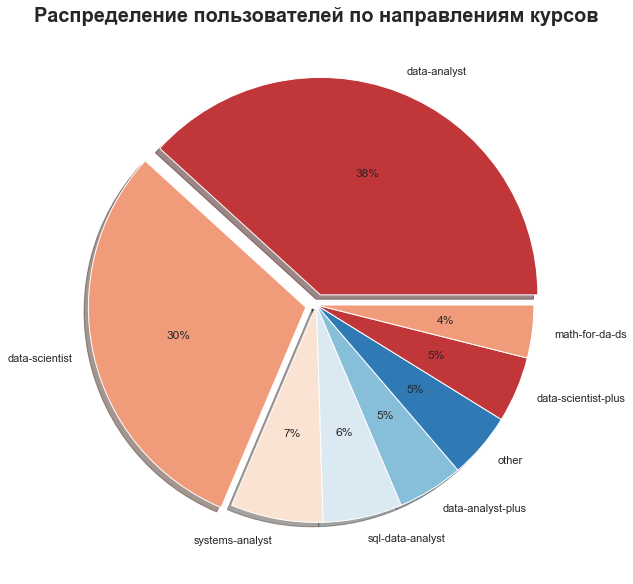

In [18]:
# Графики распределения относительного кол-ва пользователей по направлениям курсов 

# сгруппируем малочисленные направления в other в новом поле profession_group
hm['profession_group'] = hm['profession_name'].apply( 
    lambda x: 'other' if x in ['data-engineer','data-analyst-bootcamp', 'data-science-bootcamp'] else x)

# cгруппируем количество уникальныз пользователей по profession_group
prof_struct = hm.groupby('profession_group', as_index=False
                                       )['user_id'].nunique().sort_values(by='user_id',ascending=False)
# расчитаем относительные величины
prof_struct['user_percent'] = round((prof_struct['user_id']/prof_struct['user_id'].sum())*100,)
#display(prof_struct)

# пайплот пользователей по профессиям
fig = plt.figure(figsize=(10, 10))
explode = [0.05,0.05,0,0,0,0,0,0]
colors = sns.color_palette('RdBu')
plt.pie(prof_struct['user_percent'], labels=prof_struct['profession_group'], colors=colors,
        autopct='%.0f%%',  shadow=True, explode=explode)#,
plt.title("Распределение пользователей по направлениям курсов",fontweight ="bold", fontsize='20', y=1.01)

plt.savefig("professions.svg", format="svg") # сохраним график для будущей презентации
plt.savefig('professions.png')
plt.show()

Мы видим, что наибольший удельный вес занимают data-analysts и data-scientists (38% и 30% соответственно). Самые малочисленные группы пользователей объединены в сегмент other (программы data-engineer, data-analyst-bootcamp и data-science-bootcamp). 

Посмотрим распределение по названиям когорт. Сначала рассмотрим какое кол-во пользователей в когортах:

In [19]:
# сформируем сводную таблицу-отчет о числе юзеров в каждой когорте
report = pd.pivot_table(dga, index=['profession_name','cohort'],fill_value=0,
                        values = 'user_id', aggfunc='nunique', dropna=True)
contotal = report.groupby(level=0).sum().assign(profession_name='TOTAL').set_index(['profession_name'], append=True)
df_out = (pd.concat([report,contotal]).sort_index())
df_out.head(100).style.background_gradient('coolwarm')

Наибольшее количество студентов, находятся на курсе data-analyst и data-scientist. В нумерации когорт присутствует 4 когорты с 4-х значным номером: 1091, 1031,1231 и 1131, хотя большинство когорт имеет максимум трех значный номер. Вероятно здесь ошибочно добавилась единица к основному названию когорту. Заменим названия этих 4-х когорт:

In [20]:
#замена названия когорт 1091, 1031,1231 и 1131
dga.loc[dga['cohort'] == 'ds_cohort_1091','cohort'] = "ds_cohort_109"
dga.loc[dga['current_cohort'] == 'ds_cohort_1091','cohort'] = "ds_cohort_109" 
dga.loc[dga['cohort'] == 'ds_cohort_1031','cohort'] = "ds_cohort_103"
dga.loc[dga['current_cohort'] == 'ds_cohort_1031','cohort'] = "ds_cohort_103" 
dga.loc[dga['cohort'] == 'ds_cohort_1231','cohort'] = "ds_cohort_123"
dga.loc[dga['current_cohort'] == 'ds_cohort_1231','cohort'] = "ds_cohort_123" 
dga.loc[dga['cohort'] == 'ds_cohort_1131','cohort'] = "ds_cohort_113"
dga.loc[dga['current_cohort'] == 'ds_cohort_1131','cohort'] = "ds_cohort_113" 

In [21]:
#проверка замены
dga.loc[dga['cohort'] == 'ds_cohort_1091']

,Unnamed: 0,user_id,answer_date,answer_id,cohort,course_name,current_cohort,current_segment,lesson_name,original_segment,profession_name,question_title,question_type,statement_content,topic_name,user_answer


Таким образом, мы устранили ошибки в названиях когорт. Теперь посмотрим распределение:

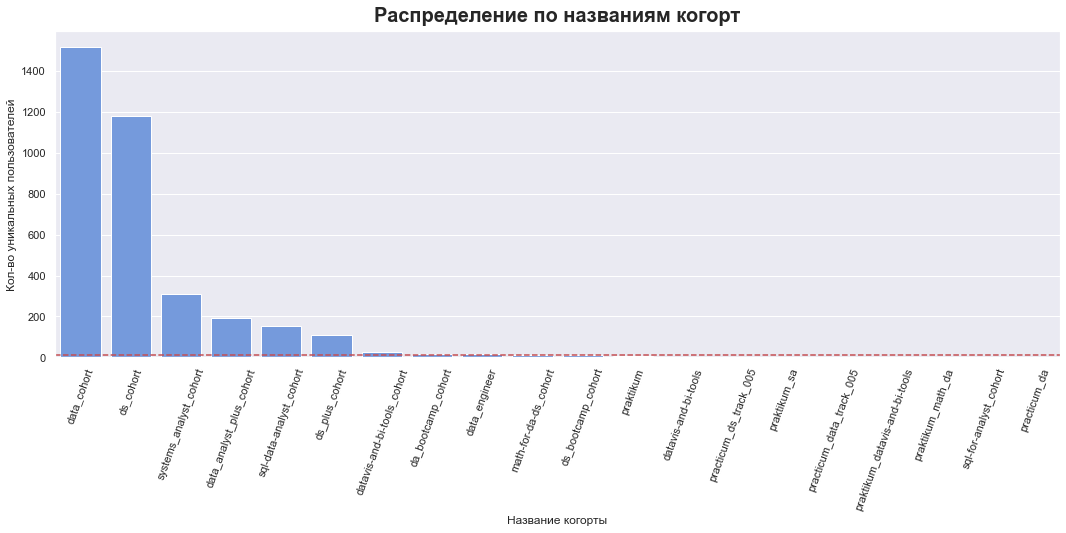

'Количество когорт по названиям'

,cohort_name,cohort_numb
17,sql-data-analyst_cohort,69
2,data_cohort,26
7,ds_cohort,26
8,ds_plus_cohort,9
1,data_analyst_plus_cohort,7
19,systems_analyst_cohort,6
9,math-for-da-ds_cohort,6
3,data_engineer,4
0,da_bootcamp_cohort,2
6,ds_bootcamp_cohort,2


In [22]:
# отбросим номера когорт и построим распределение по названиям когорт
dga['cohort_name'] = dga['cohort'].apply(lambda x: x.rsplit('_', 1)[0])# 
dga['cohort_numb'] = dga['cohort'].apply(lambda x: x.rsplit('_', 1)[-1])#

dga['current_cohort_name'] = dga['current_cohort'].apply(lambda x: x.rsplit('_', 1)[0])# 
dga['current_cohort_numb'] = dga['current_cohort'].apply(lambda x: x.rsplit('_', 1)[-1])#

cohort_stud = dga.groupby('cohort_name', as_index=False)['user_id'].nunique().sort_values(by='user_id', ascending=False)

plt.figure(figsize=[18,6])
sns.set_theme(style='darkgrid')
sns.barplot(data=cohort_stud, x='cohort_name', y='user_id', color = 'cornflowerblue')
plt.axhline(y=cohort_stud['user_id'].median(), color='r', linestyle='--')
plt.title("Распределение по названиям когорт",fontweight ="bold", fontsize='20', y=1.01)
plt.ylabel("Кол-во уникальных пользователей")
plt.xlabel("Название когорты")
plt.xticks(rotation=70)
plt.show()

display('Количество когорт по названиям')
cohort_count = dga.groupby('cohort_name', as_index=False)['cohort_numb'].nunique().sort_values(by='cohort_numb', ascending=False)
display(cohort_count)


Можно увидеть, что названия когорт в данных не всегда унифицированы. Таки образом, получились совсем малочисленные группы. С таким материалом работать неудобно. Данное поле требует дополнительной обработки и унификации. Вместе с тем, важнее всё же исследовать, как пользователи распределяются по направлениям обучения, поэтому далее будем работать с полем profession_name. 

Посмотрим, какие варианты вопросов представлены в данных:

In [23]:
dga['question_title'].unique()

array(['Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.',
       'Тут вы можете оставить свой комментарий, если не нашли подходящего варианта ответа.',
       'Бывает, что во время обучения меняется его цель. Например, изначально вы не планировали менять работу, но влюбились в профессию. Может, произошли жизненные изменения или вам сложно определить цель. Чтобы мы поняли, как помочь, отметьте подходящее утверждение:',
       'Возможно вы нашли работу за время обучения?',
       'В зависимости от опыта работы вам может понадобиться разный вид консультаций и помощи от команды сопровождения и трудоустройства. Для нас очень важен честный ответ и понимание вашего бэкграунда.',
       'Планируете ли вы записаться на Карьерный Трек?'], dtype=object)

Вопросов не очень много. Каждый с вариантами ответов стоит проанализировать отдельно. Посмотрим типы вопросов:

In [24]:
dga['question_type'].unique()

array(['checkbox', 'text', 'radio'], dtype=object)

Есть вопросы с множественным выбором, радиокнопкой и текстовые.  
Исключим текстовые и посмотрим, какие варианты ответов представлены:

In [25]:
dga.loc[dga['question_type'] != 'text']['user_answer'].unique()

array(['определение профессиональной сферы',
       'Продвинуться по карьерной лестнице.',
       'персональная карьерная консультация', 'устройство рынка труда',
       'как и куда можно расти как специалисту', 'Да',
       'сопроводительное письмо', 'резюме', 'решение тестовых заданий',
       'Нет опыта работы в IT и в направлении Анализа данных.',
       'Да, планирую записаться после диплома', 'Нет',
       'оценка шансов на трудоустройство',
       'От 1 года опыта работы в другом направлении IT.',
       'Сменить работу.', 'определение стратегии поиска работы',
       'Да, уже записался', 'прохождение собеседований',
       'оформление портфолио', 'как говорить про повышение',
       'Более 3 лет опыта работы в направлении Анализа данных.',
       'Развить свой бизнес. ', 'В активном поиске',
       'Более 3 лет опыта работы аналитиком.', 'Нет, не планирую',
       'Структурировать уже полученные навыки и знания.',
       'От 1 до 3 лет опыта работы направлении Анализа данных.',

Итак, посмотрим на каждый вопрос отдельно с его вариантами ответов:

In [26]:
dga.loc[dga['question_title'] == 
        'Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.']['user_answer'].unique()

array(['определение профессиональной сферы',
       'персональная карьерная консультация', 'устройство рынка труда',
       'как и куда можно расти как специалисту',
       'сопроводительное письмо', 'резюме', 'решение тестовых заданий',
       'оценка шансов на трудоустройство',
       'определение стратегии поиска работы', 'прохождение собеседований',
       'оформление портфолио', 'как говорить про повышение',
       'не думаю, что вы можете мне с чем-то помочь'], dtype=object)

In [27]:
dga.loc[dga['question_title'] == 
        'Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.']['question_type'].unique()

array(['checkbox'], dtype=object)

Итак, вопрос о нужных пользователю опциях программы - это вопрос с множественным выбором ответов (13 вариантов ответов)

In [28]:
dga.loc[dga['question_title'] == 
        'Бывает, что во время обучения меняется его цель. Например, изначально вы не планировали менять работу, но влюбились в профессию. Может, произошли жизненные изменения или вам сложно определить цель. Чтобы мы поняли, как помочь, отметьте подходящее утверждение:'][
            'user_answer'].unique()

array(['Продвинуться по карьерной лестнице.', 'Сменить работу.',
       'Развить свой бизнес. ',
       'Структурировать уже полученные навыки и знания.',
       'Получить новые навыки для общего развития.',
       'Получить новые знания, чтобы повысить зарплату.',
       'Нет определённой цели в обучении.'], dtype=object)

In [29]:
dga.loc[dga['question_title'] == 
        'Бывает, что во время обучения меняется его цель. Например, изначально вы не планировали менять работу, но влюбились в профессию. Может, произошли жизненные изменения или вам сложно определить цель. Чтобы мы поняли, как помочь, отметьте подходящее утверждение:'][
            'question_type'].unique()

array(['radio'], dtype=object)

Вопрос о цели обучения - радиокнопка (1 из 7 вариантов ответа)

In [30]:
dga.loc[dga['question_title'] == 
        'Возможно вы нашли работу за время обучения?']['user_answer'].unique()

array(['Да', 'Нет', 'В активном поиске'], dtype=object)

In [31]:
dga.loc[dga['question_title'] == 
        'Возможно вы нашли работу за время обучения?']['question_type'].unique()

array(['radio'], dtype=object)

In [32]:
dga.loc[dga['question_title'] == 
        'В зависимости от опыта работы вам может понадобиться разный вид консультаций и помощи от команды сопровождения и трудоустройства. Для нас очень важен честный ответ и понимание вашего бэкграунда.'][
            'user_answer'].unique()

array(['Нет опыта работы в IT и в направлении Анализа данных.',
       'От 1 года опыта работы в другом направлении IT.',
       'Более 3 лет опыта работы в направлении Анализа данных.',
       'Более 3 лет опыта работы аналитиком.',
       'От 1 до 3 лет опыта работы направлении Анализа данных.',
       'Менее 1 года опыта работы в другом направлении IT.',
       'От 1 до 3 лет опыта работы аналитиком.',
       'Нет опыта работы аналитиком и в IT.',
       'Менее года опыта работы в направлении Анализа данных.',
       'Нет опыта работы аналитиков и в IT.',
       'Менее года опыта работы аналитиком.'], dtype=object)

In [33]:
dga.loc[dga['question_title'] == 
        'В зависимости от опыта работы вам может понадобиться разный вид консультаций и помощи от команды сопровождения и трудоустройства. Для нас очень важен честный ответ и понимание вашего бэкграунда.'][
            'question_type'].unique()

array(['radio'], dtype=object)

In [34]:
dga.loc[dga['question_title'] == 
        'Планируете ли вы записаться на Карьерный Трек?']['user_answer'].unique()

array(['Да, планирую записаться после диплома', 'Да, уже записался',
       'Нет, не планирую'], dtype=object)

In [35]:
dga.loc[dga['question_title'] == 
        'Планируете ли вы записаться на Карьерный Трек?']['question_type'].unique()

array(['radio'], dtype=object)

Также радиокнопками представлены вопросы:
- Возможно вы нашли работу за время обучения?
- В зависимости от опыта работы вам может понадобиться разный вид консультаций и помощи от команды сопровождения и трудоустройства. Для нас очень важен честный ответ и понимание вашего бэкграунда
- Планируете ли вы записаться на Карьерный Трек?

Посмотрим поближе на таблицу с метриками:

In [36]:
hm.sample(1)

,Unnamed: 0,profession_name,user_id,lp_avg_user,statement_content,value,question_title,user_answer,profession_group
46668,46668,data-scientist,250815,0.76,Моя уверенность в своих знаниях значительно повысилась по сравнению с предыдущим спринтом,2,NaN,NaN,data-scientist


Также посмотрим какие уникальные значения хранятся в графах:

In [37]:
hm['statement_content'].unique()

array(['Моя уверенность в своих знаниях значительно повысилась по сравнению с предыдущим спринтом'],
      dtype=object)

In [38]:
hm['value'].unique()

array([ 2,  1, -2,  0, -1])

In [39]:
hm['question_title'].unique()

array(['Какова вероятность, что вы порекомендуете Практикум своим друзьям по шкале от 0 до 10, где 10 — обязательно порекомендую, 0 — не порекомендую ни за что?',
       nan], dtype=object)

In [40]:
hm['user_answer'].value_counts()

10.00    5502
8.00     2828
9.00     1993
7.00     1725
5.00      960
6.00      705
3.00      308
0.00      234
4.00      220
2.00      143
1.00      121
Name: user_answer, dtype: int64

Ошибок в данных не видно. Можем заметить, что удовлетворенность курсом в целом на вскидку неплохая - большинство пользователей поставили оценку 7 и более.

<a id='anchor_4'></a>
## Преобразование и объединение таблиц


Итак, надо агрегировать данную таблицу для дальнейшего исследования. Чем больше спринтов прошел студент, тем выше объективность показателя lp_avg_user. Однако, выше отмечалось, что в данных присутствует информация о студентах, которые прошли более одной программы. Посмотрим, как много таких:

In [41]:
len(hm[['profession_name', 'user_id']].groupby(by='user_id', as_index=False).agg('nunique').loc[
    hm[['profession_name', 'user_id']].groupby(by='user_id', as_index=False).agg('nunique')['profession_name'] > 1])

1740

Таких пользователей достаточно много. Таким образом получаем два поля в качестве ключа для объединения - profession_name и user_id. Далее нам необходимо сруппировать данные по двум полям и выбрать последнее значение показателя в группе:

In [42]:
hm.head()

,Unnamed: 0,profession_name,user_id,lp_avg_user,statement_content,value,question_title,user_answer,profession_group
0,0,sql-data-analyst,14641026,0.86,Моя уверенность в своих знаниях значительно повысилась по сравнению с предыдущим спринтом,2,"Какова вероятность, что вы порекомендуете Практикум своим друзьям по шкале от 0 до 10, где 10 — обязательно порекомендую, 0 — не порекомендую ни за что?",9.00,sql-data-analyst
1,1,sql-data-analyst,14641026,0.93,Моя уверенность в своих знаниях значительно повысилась по сравнению с предыдущим спринтом,2,"Какова вероятность, что вы порекомендуете Практикум своим друзьям по шкале от 0 до 10, где 10 — обязательно порекомендую, 0 — не порекомендую ни за что?",9.00,sql-data-analyst
2,2,data-analyst,14881168,0.48,Моя уверенность в своих знаниях значительно повысилась по сравнению с предыдущим спринтом,1,NaN,NaN,data-analyst
3,3,data-analyst,14881168,0.43,Моя уверенность в своих знаниях значительно повысилась по сравнению с предыдущим спринтом,1,NaN,NaN,data-analyst
4,4,data-scientist,7855703,0.61,Моя уверенность в своих знаниях значительно повысилась по сравнению с предыдущим спринтом,2,NaN,NaN,data-scientist


In [43]:
hm_transform = hm.groupby(by=['user_id', 'profession_name'], as_index=False).agg(
    {'lp_avg_user':'last', 'value':'mean', 'user_answer':['mean', 'first', 'last']})
hm_transform.columns=['user_id', 'profession_name', 'lp_avg_user', 'value', 'user_answer', 'first', 'last']

def opinion(row):
  """
Функция пройдется по каждому юзеру, сравнит первую и последнюю оценку
вероятности рекомендации Практикума и вернёт категорию (мнение ухудшилось,
улучшилось или не изменилось)
  """
  if row['last'] < row['first']:
    return 'ухудшилось'
  if row['last'] == row['first']:
    return 'не изменилось'
  if row['last'] > row['first']:
    return 'улучшилось'

hm_transform['opinion'] = hm_transform.apply(opinion, axis=1)

hm_transform.sample(5)

,user_id,profession_name,lp_avg_user,value,user_answer,first,last,opinion
3248,3974473,data-analyst,0.59,0.83,NaN,NaN,NaN,None
2206,1970872,data-scientist,0.59,1.80,NaN,NaN,NaN,None
3494,4761912,data-scientist,0.55,-0.40,NaN,NaN,NaN,None
6591,14286667,data-scientist,0.64,2.00,NaN,NaN,NaN,None
6705,14336404,data-scientist,0.88,1.00,NaN,NaN,NaN,None


Кроме того, мы добавили среднюю метрику value (ощущение об увенности в новых знаниях в баллах от -2 до 2 - используется при расчете learning experience индекса) и user_answer (вероятность рекомендации Практикума в баллах от 0 до 10). Также ввели дополнительный категориальный параметр - измениения мнения студента о курсе в процессе обучения. Если первая оценка вероятности рекомендации практикума выше, чем последняя, то мнение студента ухудшилось. И, соответственно, наоборот. Если они равны, то мнение не изменилось:

In [44]:
hm_transform.groupby(by='opinion', as_index=False).agg('count')[['opinion','user_id']]

,opinion,user_id
0,не изменилось,1628
1,улучшилось,35
2,ухудшилось,64


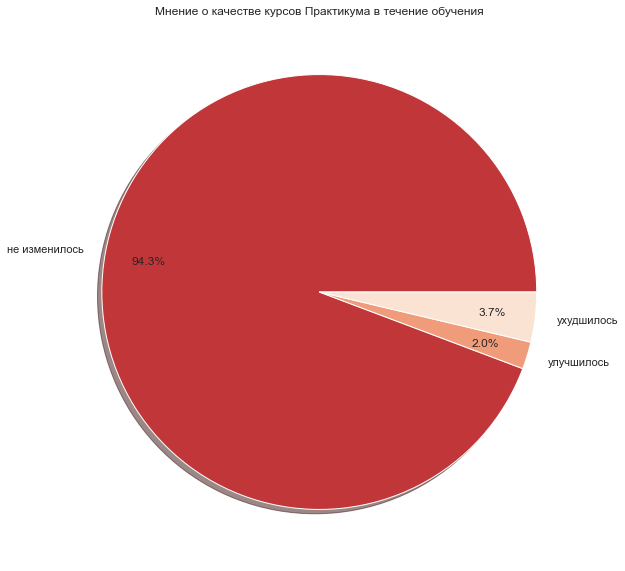

In [45]:
# построим диаграмму о динамике мнения студентов по поводу качества курсов

fig = plt.figure(figsize=(10,10))
colors = sns.color_palette('RdBu')
plt.pie(hm_transform.groupby(by='opinion', as_index=False).agg('count')['user_id'],
        labels = hm_transform.groupby(by='opinion', as_index=False).agg('count')['opinion'],
        autopct='%.01f%%', pctdistance=0.8, colors=colors, shadow=True)
plt.title('Мнение о качестве курсов Практикума в течение обучения')

plt.savefig("change_opinion.svg", format="svg") # сохраним график для будущей презентации
plt.savefig('change_opinion.png')
plt.show()

In [46]:
# удалим вспомогательные столбцы
hm_transform = hm_transform.drop(columns={'first', 'last'})
hm_transform.columns

Index(['user_id', 'profession_name', 'lp_avg_user', 'value', 'user_answer',
       'opinion'],
      dtype='object')

Мы можем видеть, что есть 3.7% пользователей, которые разочаровались в курсе в процессе обучения. Это проблемная зона - её следует изучить.

Посмотрим, как оценки вероятности рекомендации Практикума распределились по 10-бальной шкале:

In [47]:
# сформируем сводную таблицу и добавим расчет %
hm_answer = hm_transform[['user_answer', 'user_id']]
hm_answer = hm_answer.dropna()
hm_answer['user_answer'] = hm_answer['user_answer'].astype('int')
hm_answer = hm_answer.groupby(by=['user_answer'], as_index=False).agg({'user_id':'count'})
hm_answer = hm_answer.rename(columns = {'user_id':'count'})
hm_answer['answer_percent'] = round(100*hm_answer['count']/sum(hm_answer['count']), 2)
hm_answer = hm_answer.sort_values(by='count', ascending = False)
hm_answer.style.format({'answer_percent':'{:.2f}%'})

,user_answer,count,answer_percent
10,10,628,36.36%
8,8,321,18.59%
7,7,225,13.03%
9,9,219,12.68%
5,5,112,6.49%
6,6,88,5.10%
3,3,47,2.72%
4,4,28,1.62%
0,0,25,1.45%
1,1,17,0.98%


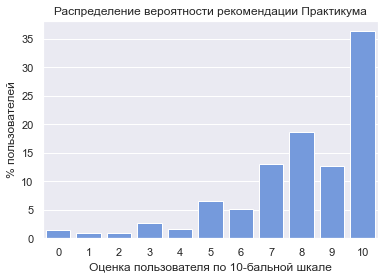

In [48]:
# функция для построения столбчатой диаграммы на основании сводной таблицы
def bar_plot(x, y, data, plot_title, x_label, y_label):
  sns.barplot(x=x, y=y, data=data, color = 'cornflowerblue')
  plt.title(plot_title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  return

bar_plot('user_answer', 'answer_percent', hm_answer, 'Распределение вероятности рекомендации Практикума',
         'Оценка пользователя по 10-бальной шкале', '% пользователей')

plt.savefig("opinion.svg", format="svg") # сохраним график для будущей презентации
plt.savefig('opinion.png')

График демонстрирует, что большая часть студентов готова рекомендовать Практикум. Они оценили вероятность такой рекомендации по 10-бальной шкале на 7 и более. Для пользователей, которые ставят балл менее 5 можно добавить дополнительный блок вопросов о проблемных местах. Так можно будет собрать информацию о том, что можно улучшить.

Посмотрим основную информацию о трансформированной таблице:

In [49]:
df_info(hm_transform)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11850 entries, 0 to 11849
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          11850 non-null  int64  
 1   profession_name  11850 non-null  object 
 2   lp_avg_user      11850 non-null  float64
 3   value            11850 non-null  float64
 4   user_answer      1727 non-null   float64
 5   opinion          1727 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory usage: 555.6+ KB

Пропуски в относительном выражении (%):


user_id            0.00
profession_name    0.00
lp_avg_user        0.00
value              0.00
user_answer       85.43
opinion           85.43
dtype: float64


Случайная выборка по данным:


,user_id,profession_name,lp_avg_user,value,user_answer,opinion
3229,3937198,systems-analyst,0.79,0.00,NaN,None
6865,14401290,data-analyst,0.75,-0.80,NaN,None
9545,15150967,data-scientist,0.91,1.67,NaN,None
7149,14500463,data-scientist,0.65,2.00,NaN,None
10948,15589309,data-analyst,0.92,1.50,NaN,None



Первичная статистика по данным:


,count,mean,std,min,25%,50%,75%,max
user_id,11850.00,10074934.89,5963015.45,377.00,3150628.00,13867971.00,14998082.00,16130827.00
lp_avg_user,11850.00,0.72,0.13,0.14,0.63,0.73,0.82,0.98
value,11850.00,0.91,0.88,-2.00,0.33,1.00,1.67,2.00
user_answer,1727.00,8.00,2.27,0.00,7.00,8.00,10.00,10.00



Количество уникальных пользователей:


9797


Количество полных дубликатов: 0



Таблицу с ответами перед объединением целесообразно из длинной формы превратить в широкую (вопросы сделаем названием столбцов):

In [50]:
dga_transform = pd.pivot_table(dga,values='user_answer', index=['user_id', 'profession_name', 'Unnamed: 0'],
                               columns=['question_title'], aggfunc='last').reset_index()
dga_transform.head()


question_title,user_id,profession_name,Unnamed: 0,"Бывает, что во время обучения меняется его цель. Например, изначально вы не планировали менять работу, но влюбились в профессию. Может, произошли жизненные изменения или вам сложно определить цель. Чтобы мы поняли, как помочь, отметьте подходящее утверждение:",В зависимости от опыта работы вам может понадобиться разный вид консультаций и помощи от команды сопровождения и трудоустройства. Для нас очень важен честный ответ и понимание вашего бэкграунда.,Возможно вы нашли работу за время обучения?,"Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции.",Планируете ли вы записаться на Карьерный Трек?,"Тут вы можете оставить свой комментарий, если не нашли подходящего варианта ответа."
0,3157,data-analyst,1,NaN,NaN,NaN,определение профессиональной сферы,NaN,NaN
1,3157,data-analyst,2,NaN,NaN,NaN,NaN,NaN,Все ок)
2,3157,data-analyst,3,Продвинуться по карьерной лестнице.,NaN,NaN,NaN,NaN,NaN
3,3157,data-analyst,4,NaN,NaN,NaN,персональная карьерная консультация,NaN,NaN
4,3157,data-analyst,5,NaN,NaN,NaN,устройство рынка труда,NaN,NaN


Сократим названия столбцов, удалим лишние и посмотрим общую информацию о трансформированной таблице:

In [51]:
dga_transform = dga_transform.drop(columns={'Unnamed: 0'})
dga_transform.columns=['user_id', 'profession_name', 'цель', 'опыт', 'работа', 'опции', 'трек', 'комментарий']
dga_transform.head()

,user_id,profession_name,цель,опыт,работа,опции,трек,комментарий
0,3157,data-analyst,NaN,NaN,NaN,определение профессиональной сферы,NaN,NaN
1,3157,data-analyst,NaN,NaN,NaN,NaN,NaN,Все ок)
2,3157,data-analyst,Продвинуться по карьерной лестнице.,NaN,NaN,NaN,NaN,NaN
3,3157,data-analyst,NaN,NaN,NaN,персональная карьерная консультация,NaN,NaN
4,3157,data-analyst,NaN,NaN,NaN,устройство рынка труда,NaN,NaN


In [52]:
df_info(dga_transform)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43416 entries, 0 to 43415
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_id          43416 non-null  int64 
 1   profession_name  43416 non-null  object
 2   цель             3534 non-null   object
 3   опыт             3560 non-null   object
 4   работа           3489 non-null   object
 5   опции            25822 non-null  object
 6   трек             3534 non-null   object
 7   комментарий      3477 non-null   object
dtypes: int64(1), object(7)
memory usage: 2.7+ MB

Пропуски в относительном выражении (%):


user_id            0.00
profession_name    0.00
цель              91.86
опыт              91.80
работа            91.96
опции             40.52
трек              91.86
комментарий       91.99
dtype: float64


Случайная выборка по данным:


,user_id,profession_name,цель,опыт,работа,опции,трек,комментарий
32094,14778398,data-analyst,NaN,NaN,NaN,сопроводительное письмо,NaN,NaN
1781,247238,datavis-and-bi-tools,NaN,NaN,NaN,NaN,NaN,Навыки нужны для применения на текущем месте работы.\nМенять текущее место работы пока не планирую.\nДля повышения/смены места работы ещё не хватает навыков и практического опыта.
15911,8834424,data-analyst,NaN,NaN,NaN,сопроводительное письмо,NaN,NaN
7189,1667683,data-scientist-plus,NaN,NaN,NaN,сопроводительное письмо,NaN,NaN
38416,15081186,data-analyst,NaN,NaN,NaN,прохождение собеседований,NaN,NaN



Первичная статистика по данным:


,count,mean,std,min,25%,50%,75%,max
user_id,43416.00,9977810.72,5839881.35,3157.00,3163975.00,13738151.00,14805767.00,16535210.00



Количество уникальных пользователей:


3549


Количество полных дубликатов: 8


Теперь посмотрим, какие цели преследуют пользователи Практикума:

In [53]:
dga_purpose = dga_transform[['цель', 'user_id']]
dga_purpose = dga_purpose.groupby(by=['цель'], as_index=False).agg({'user_id':'count'})
dga_purpose = dga_purpose.rename(columns = {'user_id':'count'})
dga_purpose['purpose_percent'] = round(100*dga_purpose['count']/sum(dga_purpose['count']), 2)
dga_purpose = dga_purpose.sort_values(by='count', ascending = False)
dga_purpose.style.format({'purpose_percent':'{:.2f}%'})

,цель,count,purpose_percent
5,Сменить работу.,2310,65.37%
2,Получить новые навыки для общего развития.,374,10.58%
1,"Получить новые знания, чтобы повысить зарплату.",349,9.88%
3,Продвинуться по карьерной лестнице.,216,6.11%
6,Структурировать уже полученные навыки и знания.,177,5.01%
0,Нет определённой цели в обучении.,67,1.90%
4,Развить свой бизнес.,41,1.16%


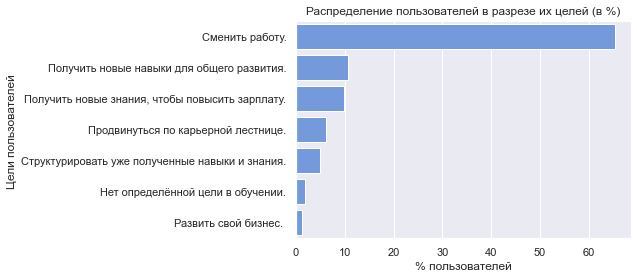

In [54]:
bar_plot('purpose_percent', 'цель', dga_purpose, 'Распределение пользователей в разрезе их целей (в %)',
         '% пользователей', 'Цели пользователей ')

plt.savefig("purposes.svg", format="svg") # сохраним график для будущей презентации
plt.savefig('purposes.png');

Более 65% приходят в Практикум с целью сменить работу. Меньше всего людей (а именно около 1.2%) хотят развить свой бизнес.

В силу того, что метрики удовлетворенности пользователей Пратикумом и его курсами хранятся в одной таблице, а цели в другой, то необходимо все данные объединить:

In [55]:
df = dga_transform.merge(hm_transform, on=['user_id', 'profession_name'], how = 'left')
df.sample(5)

,user_id,profession_name,цель,опыт,работа,опции,трек,комментарий,lp_avg_user,value,user_answer,opinion
17604,11739738,data-analyst,NaN,NaN,NaN,определение стратегии поиска работы,NaN,NaN,0.71,0.83,NaN,None
1611,226518,data-analyst,NaN,NaN,NaN,оформление портфолио,NaN,NaN,NaN,NaN,NaN,NaN
14414,6756238,data-analyst,NaN,NaN,NaN,определение стратегии поиска работы,NaN,NaN,0.84,1.00,NaN,None
14372,6700263,data-analyst-plus,NaN,NaN,NaN,устройство рынка труда,NaN,NaN,0.79,0.50,NaN,None
4607,776139,data-scientist,NaN,NaN,NaN,определение профессиональной сферы,NaN,NaN,0.73,-2.00,NaN,None


In [56]:
df_info(df)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 43416 entries, 0 to 43415
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          43416 non-null  int64  
 1   profession_name  43416 non-null  object 
 2   цель             3534 non-null   object 
 3   опыт             3560 non-null   object 
 4   работа           3489 non-null   object 
 5   опции            25822 non-null  object 
 6   трек             3534 non-null   object 
 7   комментарий      3477 non-null   object 
 8   lp_avg_user      38905 non-null  float64
 9   value            38905 non-null  float64
 10  user_answer      6537 non-null   float64
 11  opinion          6537 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 4.3+ MB

Пропуски в относительном выражении (%):


user_id            0.00
profession_name    0.00
цель              91.86
опыт              91.80
работа            91.96
опции             40.52
трек              91.86
комментарий       91.99
lp_avg_user       10.39
value             10.39
user_answer       84.94
opinion           84.94
dtype: float64


Случайная выборка по данным:


,user_id,profession_name,цель,опыт,работа,опции,трек,комментарий,lp_avg_user,value,user_answer,opinion
32094,14778398,data-analyst,NaN,NaN,NaN,сопроводительное письмо,NaN,NaN,0.70,1.00,NaN,None
1781,247238,datavis-and-bi-tools,NaN,NaN,NaN,NaN,NaN,Навыки нужны для применения на текущем месте работы.\nМенять текущее место работы пока не планирую.\nДля повышения/смены места работы ещё не хватает навыков и практического опыта.,NaN,NaN,NaN,NaN
15911,8834424,data-analyst,NaN,NaN,NaN,сопроводительное письмо,NaN,NaN,0.77,1.80,NaN,None
7189,1667683,data-scientist-plus,NaN,NaN,NaN,сопроводительное письмо,NaN,NaN,NaN,NaN,NaN,NaN
38416,15081186,data-analyst,NaN,NaN,NaN,прохождение собеседований,NaN,NaN,0.75,1.86,10.00,не изменилось



Первичная статистика по данным:


,count,mean,std,min,25%,50%,75%,max
user_id,43416.00,9977810.72,5839881.35,3157.00,3163975.00,13738151.00,14805767.00,16535210.00
lp_avg_user,38905.00,0.71,0.12,0.14,0.62,0.71,0.80,0.98
value,38905.00,0.88,0.86,-2.00,0.33,1.00,1.60,2.00
user_answer,6537.00,8.33,2.01,0.00,7.00,9.00,10.00,10.00



Количество уникальных пользователей:


3549


Количество полных дубликатов: 8


In [57]:
df = df.drop_duplicates().reset_index()

<a id='anchor_5'></a>
## Проблемы студентов

Так как нам нужно понять проблемы студентов, то посмотрим, как распределяются метрики, характеризующие удовлетворённость полученными знаниями и курсами Практикума - lp_avg_user, value, user_answer и opinion.

lp_avg_user - learning performanse, средние оценки знаний студента по разным квизам и тестам. Итак, распределение:

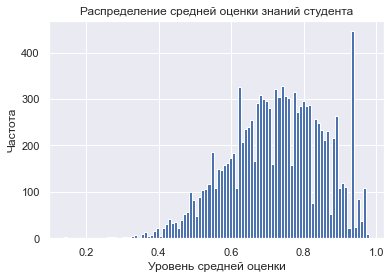

In [58]:
hm_transform['lp_avg_user'].hist(bins = 100)
plt.title('Распределение средней оценки знаний студента')
plt.xlabel('Уровень средней оценки')
plt.ylabel('Частота');

Распределение похоже на нормальное. Мы можем видеть, что наиболее часто появляется средний балл на уровне 0.6 - 0.8

Следующая метрика value - ответ на вопрос об уверенности в знаниях (оценивается в баллах от -2 до 2) для расчета learning experience. При агрегации мы получили среднее значение по юзеру в пределах однойф учебной программы. Построим распределение:

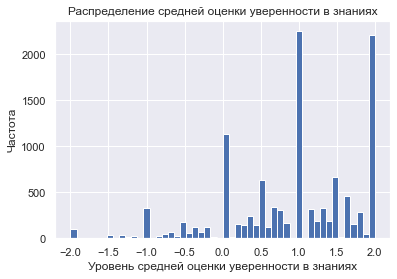

In [59]:
hm_transform['value'].hist(bins = 50)
plt.title('Распределение средней оценки уверенности в знаниях')
plt.xlabel('Уровень средней оценки уверенности в знаниях')
plt.ylabel('Частота');

По распределению можно увидеть, что большинство пользователей ставили положительные баллы.

А также посмотрим, с какой средней вероятностью студенты чаще всего рекомендуют Практикум (в баллах от 0 до 10):

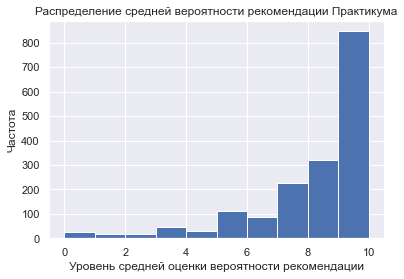

In [60]:
hm_transform['user_answer'].hist(bins = 10)
plt.title('Распределение средней вероятности рекомендации Практикума')
plt.xlabel('Уровень средней оценки вероятности рекомендации')
plt.ylabel('Частота');

Как уже отмечалось ранее, мы видим, что преобладают высокие баллы по метрике - от 7 и выше.

Чем ниже вышеупомянутые характеристки, тем меньше доволен студент. Выберем тех, кто показал низкий lp_avg_user (по 25% квартилю) и посмотрим на этих юзеров в разрезе направлений обучения:

In [61]:
# сформируем вспомогательную таблицу с расчетом числа пользователей в каждом направлении обучения
profs = hm_transform[['profession_name', 'user_id']].groupby(by='profession_name', as_index=False).agg('count').sort_values(
    by='user_id', ascending = False)
profs.columns = ['profession_name','prof_count']
profs = profs.loc[(profs['profession_name'] != 'data-analyst-bootcamp')&(profs['profession_name'] != 'data-science-bootcamp')]
profs

,profession_name,prof_count
0,data-analyst,4566
5,data-scientist,3679
9,systems-analyst,782
8,sql-data-analyst,696
2,data-analyst-plus,589
6,data-scientist-plus,554
7,math-for-da-ds,421
3,data-engineer,368


25% пользователей имеют средний learning performance на уровне от 0.63 - данное значение и определим как пороговое для неудовлетворительной метрики. Сформируем срез и посмотрим распределение:

In [62]:
low_lp = hm_transform.loc[hm_transform['lp_avg_user'] <= 0.63]
group_low = low_lp[['profession_name', 'user_id']].groupby(by='profession_name', as_index=False).agg('count')
group_low = profs.merge(group_low, on='profession_name', how = 'left')
group_low['percent'] = round(100*group_low['user_id']/group_low['prof_count'],2)
group_low = group_low.sort_values(by='percent', ascending = False)
group_low.style.format({'percent':'{:.2f}%'})

,profession_name,prof_count,user_id,percent
6,math-for-da-ds,421,210,49.88%
0,data-analyst,4566,1356,29.70%
1,data-scientist,3679,1030,28.00%
4,data-analyst-plus,589,120,20.37%
5,data-scientist-plus,554,99,17.87%
7,data-engineer,368,27,7.34%
3,sql-data-analyst,696,48,6.90%
2,systems-analyst,782,5,0.64%


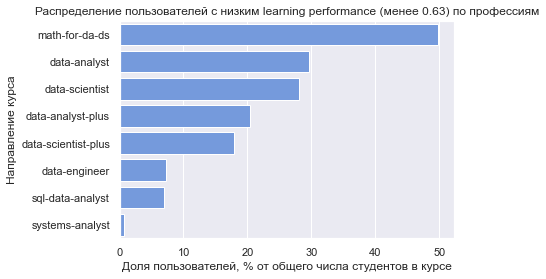

In [63]:
bar_plot('percent', 'profession_name', group_low, 'Распределение пользователей с низким learning performance (менее 0.63) по профессиям',
         'Доля пользователей, % от общего числа студентов в курсе', 'Направление курса')

plt.savefig("low_tp.svg", format="svg") # сохраним график для будущей презентации
plt.savefig('low_lp.png');

видим, что доработки требуют программа математики для аналитиков/сайнтистов - практически половина пользователей имеют неудовлетворительную оценку. Следует изучить все тесты, предложенные студентам, определить те, что вызывают больше всего трудностей, пересмотреть подачу соответствующего материала в курсе. Возможно, нужно добавить больше примеров или задач на закрепление материала.

Посмотрим аналогичным образом на value - оценку уверенности в знаниях (25% студентов имеют оценку менее 0.33):

In [64]:
low_value = hm_transform.loc[hm_transform['value'] <= 0.33]
group_val = low_value[['profession_name', 'user_id']].groupby(by='profession_name', as_index=False).agg('count')
group_val = profs.merge(group_val, on='profession_name', how = 'left')
group_val['percent'] = round(100*group_val['user_id']/group_val['prof_count'],2)
group_val = group_val.sort_values(by='percent', ascending = False)
group_val.style.format({'percent':'{:.2f}%'})

,profession_name,prof_count,user_id,percent
7,data-engineer,368,111,30.16%
0,data-analyst,4566,1124,24.62%
1,data-scientist,3679,888,24.14%
5,data-scientist-plus,554,132,23.83%
4,data-analyst-plus,589,140,23.77%
6,math-for-da-ds,421,87,20.67%
3,sql-data-analyst,696,134,19.25%
2,systems-analyst,782,96,12.28%


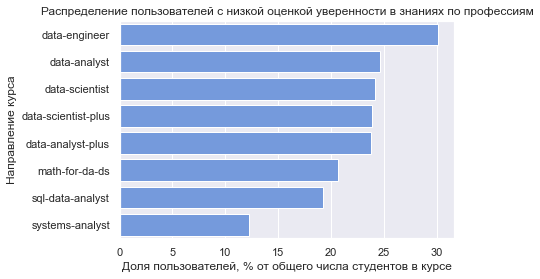

In [65]:
bar_plot('percent', 'profession_name', group_val, 'Распределение пользователей с низкой оценкой уверенности в знаниях по профессиям',
         'Доля пользователей, % от общего числа студентов в курсе', 'Направление курса')

plt.savefig("low_value.svg", format="svg") # сохраним график для будущей презентации
plt.savefig('low_value.png');

Диаграмма демонстрирует, что студенты из программы дата инженеров чаще других не ощущают уверенность в приобретённых знаниях. Можно предложить добавить опросник в этой программе о том, что именно не до конца поняли студенты, и соответственно дорабатывать эти блоки обучения.

Ну и посмотрим, какие направления реже других стали бы рекомендовать Практикум (25% пользователей оценили эту вероятность менее 7 баллов):

In [66]:
low_answer = hm_transform.loc[hm_transform['user_answer'] < 7]
group_ans = low_answer[['profession_name', 'user_id']].groupby(by='profession_name', as_index=False).agg('count')
group_ans = profs.merge(group_ans, on='profession_name', how = 'left')
group_ans['percent'] = round(100*group_ans['user_id']/group_ans['prof_count'],2)
group_ans = group_ans.sort_values(by='percent', ascending = False)
group_ans.style.format({'percent':'{:.2f}%'})

,profession_name,prof_count,user_id,percent
7,data-engineer,368,76.000000,20.65%
3,sql-data-analyst,696,28.000000,4.02%
6,math-for-da-ds,421,14.000000,3.33%
5,data-scientist-plus,554,17.000000,3.07%
0,data-analyst,4566,106.000000,2.32%
1,data-scientist,3679,80.000000,2.17%
4,data-analyst-plus,589,4.000000,0.68%
2,systems-analyst,782,nan,nan%


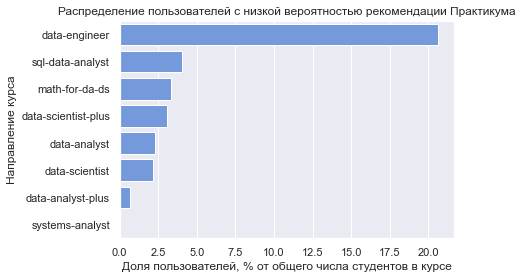

In [67]:
bar_plot('percent', 'profession_name', group_ans, 'Распределение пользователей с низкой вероятностью рекомендации Практикума',
         'Доля пользователей, % от общего числа студентов в курсе', 'Направление курса')

Итак, следует обратить внимание на курс дата-инженеров. Они чаще других не готовы рекомендовать Практикум. Вероятно, стоит посмотреть аналогичные программы конкурентов и попробовать найти пути совершенствования курса.

Последнее в этом блоке сравнение посмотрим в разрезе добавленной нами метрики - изменение мнения по поводу рекоммендации Практикума в течение обучения. Посмотрим, чьё мнение ухудшилось:

In [68]:
low_opinion = hm_transform.loc[hm_transform['opinion'] == 'ухудшилось']
group_op = low_opinion[['profession_name', 'user_id']].groupby(by='profession_name', as_index=False).agg('count')
group_op = profs.merge(group_op, on='profession_name', how = 'left')
group_op['percent'] = round(100*group_op['user_id']/group_op['prof_count'],2)
group_op = group_op.sort_values(by='percent', ascending = False)
group_op.style.format({'percent':'{:.2f}%'})

,profession_name,prof_count,user_id,percent
7,data-engineer,368,47.000000,12.77%
3,sql-data-analyst,696,5.000000,0.72%
4,data-analyst-plus,589,2.000000,0.34%
5,data-scientist-plus,554,1.000000,0.18%
0,data-analyst,4566,5.000000,0.11%
1,data-scientist,3679,3.000000,0.08%
2,systems-analyst,782,nan,nan%
6,math-for-da-ds,421,nan,nan%


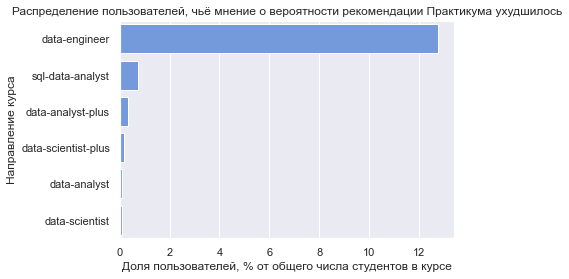

In [69]:
bar_plot('percent', 'profession_name', group_op.loc[(group_op['profession_name'] != 'systems-analyst') &
                                                    (group_op['profession_name'] != 'math-for-da-ds')],
          'Распределение пользователей, чьё мнение о вероятности рекомендации Практикума ухудшилось',
         'Доля пользователей, % от общего числа студентов в курсе', 'Направление курса')

Таким образом, курс для дата-инженеров чаще других оставляет недовольными студентов, а соответственно требует доработки. Можно попробовать изучить требования к кандидатам в данной профессии, которые требуются на рынке, произвести сравнение с текущей программой и совершенствовать её.

<a id='anchor_6'></a>
## Портреты пользователей

Попробуем понять, какими признаками обладает средний клиент Практикума в каждом учебном направлении.  
Для этого нам необходимо снова трансформировать таблицу с ответами, но на этот раз столбцами станут не только вопросы, но и ответы юзеров. А в ячейках булевы значения - обладает юзер данным признаком, или нет.

In [70]:
# сформируем таблицу, где в столбцах будут вопросы, а в ячейках ответы,
# сгруппируем по user_id и profession_name
pivot_quest = pd.pivot_table(dga,
                                values='user_answer', 
                                index=['user_id', 'profession_name'], 
                                columns=['question_title'], 
                                aggfunc='last').reset_index()

# присвоим краткие имена столбцам
pivot_quest = pivot_quest.set_axis(['user_id', 
                                    'profession_name',
                                    'цель', 
                                    'опыт',
                                   'работа',
                                   'опции',
                                   'трек',
                                   'комментарий'], axis=1, inplace=False)

# удалим столбцы с опциями (это вопрос в множественным выбором ответов, здесь он некорректно агрегируется)
# и с комментарием пользователей - ответ в произвольной форме
pivot_quest = pivot_quest.drop(['опции','комментарий'],axis=1)
display(pivot_quest.info())
pivot_quest.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3559 entries, 0 to 3558
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_id          3559 non-null   int64 
 1   profession_name  3559 non-null   object
 2   цель             3533 non-null   object
 3   опыт             3559 non-null   object
 4   работа           3488 non-null   object
 5   трек             3533 non-null   object
dtypes: int64(1), object(5)
memory usage: 167.0+ KB


None

,user_id,profession_name,цель,опыт,работа,трек
0,3157,data-analyst,Продвинуться по карьерной лестнице.,Нет опыта работы в IT и в направлении Анализа данных.,Да,"Да, планирую записаться после диплома"
1,5415,data-analyst,Сменить работу.,От 1 года опыта работы в другом направлении IT.,Нет,"Да, планирую записаться после диплома"
2,8199,data-analyst,Сменить работу.,Нет опыта работы в IT и в направлении Анализа данных.,Нет,"Да, уже записался"
3,8215,data-scientist,Сменить работу.,Нет опыта работы в IT и в направлении Анализа данных.,Нет,"Да, планирую записаться после диплома"
4,10202,data-analyst-plus,Развить свой бизнес.,Более 3 лет опыта работы в направлении Анализа данных.,Нет,"Да, уже записался"


Воспользуемся функцией get_dummies(), которая в названиях столбцов склеит вопросы с соответствующими ответами и расставит булевы значения:

In [71]:
dum_ans = pd.get_dummies(pivot_quest, columns=['цель', 
                                    'опыт',
                                   'работа',
                                   'трек'], drop_first=False)
dum_ans.head()

,user_id,profession_name,цель_Нет определённой цели в обучении.,"цель_Получить новые знания, чтобы повысить зарплату.",цель_Получить новые навыки для общего развития.,цель_Продвинуться по карьерной лестнице.,цель_Развить свой бизнес.,цель_Сменить работу.,цель_Структурировать уже полученные навыки и знания.,опыт_Более 3 лет опыта работы аналитиком.,опыт_Более 3 лет опыта работы в направлении Анализа данных.,опыт_Менее 1 года опыта работы в другом направлении IT.,опыт_Менее года опыта работы аналитиком.,опыт_Менее года опыта работы в направлении Анализа данных.,опыт_Нет опыта работы аналитиков и в IT.,опыт_Нет опыта работы аналитиком и в IT.,опыт_Нет опыта работы в IT и в направлении Анализа данных.,опыт_От 1 года опыта работы в другом направлении IT.,опыт_От 1 до 3 лет опыта работы аналитиком.,опыт_От 1 до 3 лет опыта работы направлении Анализа данных.,работа_В активном поиске,работа_Да,работа_Нет,"трек_Да, планирую записаться после диплома","трек_Да, уже записался","трек_Нет, не планирую"
0,3157,data-analyst,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0
1,5415,data-analyst,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0
2,8199,data-analyst,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
3,8215,data-scientist,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
4,10202,data-analyst-plus,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


Отдельно трансформируем в широкую форму столбец с опциями, а затем присоединим к текущей таблице.

In [72]:
options = dga_transform[['user_id', 'profession_name', 'опции']]
options['опции'].unique()

array(['определение профессиональной сферы', nan,
       'персональная карьерная консультация', 'устройство рынка труда',
       'как и куда можно расти как специалисту',
       'сопроводительное письмо', 'резюме', 'решение тестовых заданий',
       'оценка шансов на трудоустройство',
       'определение стратегии поиска работы', 'прохождение собеседований',
       'оформление портфолио', 'как говорить про повышение',
       'не думаю, что вы можете мне с чем-то помочь'], dtype=object)

In [73]:
options['определение профессиональной сферы'] = options['опции'].apply(lambda x: 1 if x == 'определение профессиональной сферы' else 0)
options['персональная карьерная консультация'] = options['опции'].apply(lambda x: 1 if x == 'оперсональная карьерная консультация' else 0)
options['устройство рынка труда'] = options['опции'].apply(lambda x: 1 if x == 'устройство рынка труда' else 0)
options['как и куда можно расти как специалисту'] = options['опции'].apply(lambda x: 1 if x == 'как и куда можно расти как специалисту' else 0)
options['сопроводительное письмо'] = options['опции'].apply(lambda x: 1 if x == 'сопроводительное письмо' else 0)
options['резюме'] = options['опции'].apply(lambda x: 1 if x == 'резюме' else 0)
options['решение тестовых заданий'] = options['опции'].apply(lambda x: 1 if x == 'решение тестовых заданий' else 0)
options['оценка шансов на трудоустройство'] = options['опции'].apply(lambda x: 1 if x == 'оценка шансов на трудоустройство' else 0)
options['определение стратегии поиска работы'] = options['опции'].apply(lambda x: 1 if x == 'определение стратегии поиска работы' else 0)
options['прохождение собеседований'] = options['опции'].apply(lambda x: 1 if x == 'прохождение собеседований' else 0)
options['оформление портфолио'] = options['опции'].apply(lambda x: 1 if x == 'оформление портфолио' else 0)
options['как говорить про повышение'] = options['опции'].apply(lambda x: 1 if x == 'как говорить про повышение' else 0)
options['не думаю, что вы можете мне с чем-то помочь'] = options['опции'].apply(
    lambda x: 1 if x == 'не думаю, что вы можете мне с чем-то помочь' else 0)
options = options.drop(['опции'],axis=1)
options.sample(5)

,user_id,profession_name,определение профессиональной сферы,персональная карьерная консультация,устройство рынка труда,как и куда можно расти как специалисту,сопроводительное письмо,резюме,решение тестовых заданий,оценка шансов на трудоустройство,определение стратегии поиска работы,прохождение собеседований,оформление портфолио,как говорить про повышение,"не думаю, что вы можете мне с чем-то помочь"
15182,7870687,data-scientist,0,0,0,0,0,0,0,0,0,0,0,0,0
4691,791098,data-analyst,0,0,0,0,0,0,0,0,0,1,0,0,0
10069,2774169,data-analyst,1,0,0,0,0,0,0,0,0,0,0,0,0
33735,14872035,data-scientist,0,0,0,0,0,0,0,0,0,0,0,1,0
2149,294906,data-analyst,0,0,0,1,0,0,0,0,0,0,0,0,0


In [74]:
options.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43416 entries, 0 to 43415
Data columns (total 15 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   user_id                                      43416 non-null  int64 
 1   profession_name                              43416 non-null  object
 2   определение профессиональной сферы           43416 non-null  int64 
 3   персональная карьерная консультация          43416 non-null  int64 
 4   устройство рынка труда                       43416 non-null  int64 
 5   как и куда можно расти как специалисту       43416 non-null  int64 
 6   сопроводительное письмо                      43416 non-null  int64 
 7   резюме                                       43416 non-null  int64 
 8   решение тестовых заданий                     43416 non-null  int64 
 9   оценка шансов на трудоустройство             43416 non-null  int64 
 10  определени

In [75]:
options = options.groupby(by=['user_id', 'profession_name'], as_index=False).agg('sum')
options.head()


,user_id,profession_name,определение профессиональной сферы,персональная карьерная консультация,устройство рынка труда,как и куда можно расти как специалисту,сопроводительное письмо,резюме,решение тестовых заданий,оценка шансов на трудоустройство,определение стратегии поиска работы,прохождение собеседований,оформление портфолио,как говорить про повышение,"не думаю, что вы можете мне с чем-то помочь"
0,3157,data-analyst,1,0,1,1,1,1,1,0,0,0,0,0,0
1,5415,data-analyst,1,0,1,1,0,0,0,1,1,0,0,0,0
2,8199,data-analyst,0,0,0,0,0,0,1,0,1,1,1,0,0
3,8215,data-scientist,1,0,1,1,1,1,1,1,1,1,1,1,0
4,10202,data-analyst-plus,0,0,0,1,1,1,0,1,1,0,1,0,0


Теперь соединим полученные таблицы по двум ключам: user_id и profession_name:

In [76]:
dum_answer = pd.merge(dum_ans, options, on=['user_id', 'profession_name'], how='left')
dum_answer.sample(5)

,user_id,profession_name,цель_Нет определённой цели в обучении.,"цель_Получить новые знания, чтобы повысить зарплату.",цель_Получить новые навыки для общего развития.,цель_Продвинуться по карьерной лестнице.,цель_Развить свой бизнес.,цель_Сменить работу.,цель_Структурировать уже полученные навыки и знания.,опыт_Более 3 лет опыта работы аналитиком.,опыт_Более 3 лет опыта работы в направлении Анализа данных.,опыт_Менее 1 года опыта работы в другом направлении IT.,опыт_Менее года опыта работы аналитиком.,опыт_Менее года опыта работы в направлении Анализа данных.,опыт_Нет опыта работы аналитиков и в IT.,...,"трек_Да, уже записался","трек_Нет, не планирую",определение профессиональной сферы,персональная карьерная консультация,устройство рынка труда,как и куда можно расти как специалисту,сопроводительное письмо,резюме,решение тестовых заданий,оценка шансов на трудоустройство,определение стратегии поиска работы,прохождение собеседований,оформление портфолио,как говорить про повышение,"не думаю, что вы можете мне с чем-то помочь"
3368,15259219,data-analyst,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0,1,1,1,0,0
398,810796,data-scientist-plus,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0,1,1,1,0,0
1584,12691432,sql-data-analyst,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1,1,1,1,0,0
3537,15772921,sql-data-analyst,0,0,0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,1,1,1,0,0,0
1633,12922590,data-scientist,0,0,0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,1,1,1,1,1,1,0,1,0,0


Таким образом, мы можем сгруппировать полученную таблицу по направлениям обучения и посчитать сумму присутствующих аналогичных признаков - получим типичный портрет клиента Практикума в каждом направлении обучения:

In [77]:
dum_answer.groupby('profession_name').agg('sum').T

profession_name,data-analyst,data-analyst-bootcamp,data-analyst-plus,data-engineer,data-science-bootcamp,data-scientist,data-scientist-plus,datavis-and-bi-tools,math-for-da-ds,sql-data-analyst,systems-analyst
user_id,15847914573.00,179996924.00,1861671929.00,64005699.00,109681157.00,11729836737.00,883778666.00,215743337.00,74166393.00,1445687825.00,2937798969.00
цель_Нет определённой цели в обучении.,28.00,0.00,7.00,0.00,0.00,20.00,2.00,2.00,0.00,2.00,6.00
"цель_Получить новые знания, чтобы повысить зарплату.",135.00,1.00,15.00,4.00,1.00,107.00,5.00,7.00,1.00,26.00,47.00
цель_Получить новые навыки для общего развития.,134.00,0.00,17.00,1.00,1.00,134.00,15.00,8.00,2.00,28.00,34.00
цель_Продвинуться по карьерной лестнице.,70.00,0.00,10.00,2.00,1.00,73.00,8.00,6.00,1.00,18.00,27.00
цель_Развить свой бизнес.,14.00,0.00,4.00,0.00,0.00,19.00,1.00,0.00,0.00,1.00,2.00
цель_Сменить работу.,1079.00,17.00,130.00,6.00,5.00,768.00,76.00,4.00,6.00,64.00,154.00
цель_Структурировать уже полученные навыки и знания.,52.00,0.00,6.00,1.00,1.00,53.00,3.00,3.00,1.00,14.00,43.00
опыт_Более 3 лет опыта работы аналитиком.,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28.00
опыт_Более 3 лет опыта работы в направлении Анализа данных.,45.00,0.00,9.00,2.00,1.00,65.00,5.00,6.00,2.00,20.00,5.00


Так, например мы можем видеть, что дата-аналитики и дата-сайнтисты Практикума чаще всего обладают признаками:
- приходят с целью сменить работу,
- у них нет опыта работы в IT или направлении анализа данных,
- не нашли или находятся в активном поиске работы,
- либо участвуют, либо планируют записаться в карьерный трек,
- из опций карьерного трека их в большей степени интересует резюме, сопроводительное письмо, решение тестовых заданий, определение стратегии поиска работы, прохождение собеседований и оформление портфолио.

Дата-инженеры:
- хотят сменить работу,
- имеют от года до 3 лет опыта работы в направлении анализа данных,
- либо не нашли, либо активно ищут работу,
- планируют записаться в карьерный трек после диплома,
- в карьерном треке больше всего их интересует резюме, сопроводительное письмо, оценка шансов на трудоустройство, прохождение собеседований и оформление портфолио.

Как мы можем видеть, подавляющее большинство людей обращаются к Практикуму с целью сменить работу. Однако, интересно посмотреть, чего ждут от обучения люди, которые преследуют другие цели:

In [78]:
dum_answer.loc[dum_answer['цель_Сменить работу.'] == 0].groupby('profession_name').agg('sum').T

profession_name,data-analyst,data-analyst-bootcamp,data-analyst-plus,data-engineer,data-science-bootcamp,data-scientist,data-scientist-plus,datavis-and-bi-tools,math-for-da-ds,sql-data-analyst,systems-analyst
user_id,4201729710.00,14194987.00,525054027.00,22645195.00,40514551.00,4020541048.00,304403958.00,194660458.00,15484590.00,871846414.00,1398625200.00
цель_Нет определённой цели в обучении.,28.00,0.00,7.00,0.00,0.00,20.00,2.00,2.00,0.00,2.00,6.00
"цель_Получить новые знания, чтобы повысить зарплату.",135.00,1.00,15.00,4.00,1.00,107.00,5.00,7.00,1.00,26.00,47.00
цель_Получить новые навыки для общего развития.,134.00,0.00,17.00,1.00,1.00,134.00,15.00,8.00,2.00,28.00,34.00
цель_Продвинуться по карьерной лестнице.,70.00,0.00,10.00,2.00,1.00,73.00,8.00,6.00,1.00,18.00,27.00
цель_Развить свой бизнес.,14.00,0.00,4.00,0.00,0.00,19.00,1.00,0.00,0.00,1.00,2.00
цель_Сменить работу.,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
цель_Структурировать уже полученные навыки и знания.,52.00,0.00,6.00,1.00,1.00,53.00,3.00,3.00,1.00,14.00,43.00
опыт_Более 3 лет опыта работы аналитиком.,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,20.00
опыт_Более 3 лет опыта работы в направлении Анализа данных.,30.00,0.00,3.00,1.00,1.00,45.00,5.00,5.00,1.00,19.00,4.00


Следующей по популярности целью обучения является получение новых знаний либо для повышения зарплаты, либо для общего развития.
Так, например, системные аналитики:
- хотят повысить зарплату,
- имеют опыт либо в другом направлении IT, либо от года до трёх лет опыта работы аналитиком,
- за время обучения не нашли работу,
- планируют записаться в карьерный трек после диплома,
- в карьерном треке их интересует как и куда можно расти специалисту, сопроводительное письмо, резюме, решение тестовых заданий, прохождение собеседований, оформление портфолио и как говорить про повышение.

Можно попробовать сравнить степень удовлетворённости обучением в Практикуме по двум главным группам: те, кто пришёл с целью сменить работу и те, кто преследовал другую цель.


In [79]:
# сформируем вспомогательную таблицу, где оставим только нужные столбцы и добавим категориальный признак по цели
untypical_portrait = df[['user_id', 'profession_name', 'цель', 'lp_avg_user', 'value', 'user_answer']]
untypical_portrait = untypical_portrait.dropna(subset=['цель'])
untypical_portrait['purpose'] = untypical_portrait['цель'].apply(lambda x: 'Другая.' if x != 'Сменить работу.' else x)
untypical_portrait.head()

,user_id,profession_name,цель,lp_avg_user,value,user_answer,purpose
2,3157,data-analyst,Продвинуться по карьерной лестнице.,0.65,1.25,NaN,Другая.
21,5415,data-analyst,Сменить работу.,0.85,0.00,NaN,Сменить работу.
31,8199,data-analyst,Сменить работу.,0.71,-0.17,NaN,Сменить работу.
46,8215,data-scientist,Сменить работу.,0.76,0.17,NaN,Сменить работу.
60,10202,data-analyst-plus,Развить свой бизнес.,0.71,0.50,NaN,Другая.


In [80]:
untypical_portrait['purpose'].value_counts()

Сменить работу.    2309
Другая.            1224
Name: purpose, dtype: int64

In [81]:
# сформируем вспомогательную таблицу с расчетом числа пользователей в каждом направлении обучения,
# которые принимали участие в опросе о цели обучения
profs_df = untypical_portrait[['profession_name', 'user_id']].groupby(by='profession_name', as_index=False).agg('count').sort_values(
    by='user_id', ascending = False)
profs_df.columns = ['profession_name','prof_count']
profs_df = profs_df.loc[(profs_df['profession_name'] != 'data-analyst-bootcamp') &
                        (profs_df['profession_name'] != 'data-science-bootcamp') &
                        (profs_df['profession_name'] != 'datavis-and-bi-tools')]    # уберем самые малочисленные группы
profs_df

,profession_name,prof_count
0,data-analyst,1512
5,data-scientist,1174
10,systems-analyst,313
2,data-analyst-plus,189
9,sql-data-analyst,153
6,data-scientist-plus,110
3,data-engineer,14
8,math-for-da-ds,11


In [82]:
# выполним группировку и в %-ном отношении посмотрим, как распределяются пользователи по цели внутри каждого направления обучения
portrait_plot = untypical_portrait.groupby(by=['profession_name', 'purpose'], as_index=False).agg({'user_id':'count'})
portrait_plot = portrait_plot.rename(columns = {'user_id':'count'})
portrait_plot = profs_df.merge(portrait_plot, on='profession_name', how = 'left')
portrait_plot['percent'] = round(100*portrait_plot['count']/portrait_plot['prof_count'],2)
portrait_plot.style.format({'percent':'{:.2f}%'})

,profession_name,prof_count,purpose,count,percent
0,data-analyst,1512,Другая.,433,28.64%
1,data-analyst,1512,Сменить работу.,1079,71.36%
2,data-scientist,1174,Другая.,406,34.58%
3,data-scientist,1174,Сменить работу.,768,65.42%
4,systems-analyst,313,Другая.,159,50.80%
5,systems-analyst,313,Сменить работу.,154,49.20%
6,data-analyst-plus,189,Другая.,59,31.22%
7,data-analyst-plus,189,Сменить работу.,130,68.78%
8,sql-data-analyst,153,Другая.,89,58.17%
9,sql-data-analyst,153,Сменить работу.,64,41.83%


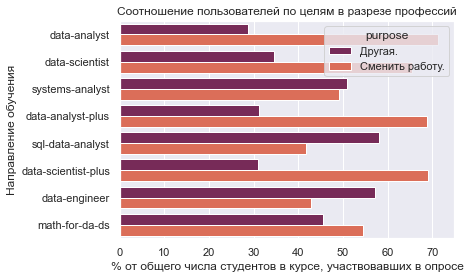

In [83]:
# отразим полученную группировку на диаграмме
sns.barplot(x='percent', y='profession_name', hue='purpose', data=portrait_plot, palette = "rocket")
plt.title('Cоотношение пользователей по целям в разрезе профессий')
plt.xlabel('% от общего числа студентов в курсе, участвовавших в опросе')
plt.ylabel('Направление обучения');

По диаграмме можно заметить, что пользователи курсов системных аналитиков, дата-инженеров и SQL для аналитиков и сайнтистов чаще других обращаются к Практикуму с другими целями.  
По таблице выше мы можем увидеть самые популярные из них:
- у системных аналитиков: получить новые знания, чтобы повысить зарплату, получить новые знания для общего развития и продвинуться по карьерной лестнице
- у дата-инженеров: получить новые знания, чтобы повысить зарплату и продвинуться по карьерной лестнице
- SQL для аналитиков и сайнтистов: получить новые знания, чтобы повысить зарплату, получить новые знания для общего развития

Таким образом, в данных направлениях обучения в карьерном треке актуально развивать темы повышения зарплаты и карьерного роста.

Посмотрим, как ведут себя метрики удовлетворённости пользователей в бинарной классификации целей:

In [84]:
untypical_portrait.groupby(by='purpose').agg('mean')

,user_id,lp_avg_user,value,user_answer
purpose,,,,
Другая.,9266482.12,0.72,0.83,8.20
Сменить работу.,10281759.23,0.70,0.89,8.36


Разница кажется незначистельной. Посмотрим дополнительно в разрезе направлений обучения:

In [85]:
untypical_portrait.groupby(by=['purpose', 'profession_name']).agg('mean')

user_id  lp_avg_user  value  \
purpose         profession_name                                         
Другая.         data-analyst           9482597.38         0.67   0.77   
                data-analyst-bootcamp 14194987.00         0.81  -0.56   
                data-analyst-plus      8401931.54         0.74   0.95   
                data-engineer          2830649.38         0.78   0.64   
                data-science-bootcamp 10128637.75         0.93   1.00   
                data-scientist         9704696.58         0.68   0.68   
                data-scientist-plus    8953057.59         0.69   0.95   
                datavis-and-bi-tools   6311636.88          NaN    NaN   
                math-for-da-ds         3096918.00         0.67   1.31   
                sql-data-analyst       9442894.82         0.79   1.20   
                systems-analyst        8796384.91         0.87   1.18   
Сменить работу. data-analyst          10793498.48         0.68   0.89   
                data-analyst-bootcamp  9753055.12         0.72   0.99   
                data-analyst-plus     10281676.17         0.73   1.03   
                data-engineer          6893417.33         0.84   1.42   
                data-science-bootcamp 13833321.20         0.66   1.38   
                data-scientist        10038145.43         0.69   0.78   
                data-scientist-plus    7623351.42         0.72   0.72   
                datavis-and-bi-tools   5270719.75          NaN    NaN   
                math-for-da-ds         9780300.50         0.60   0.75   
                sql-data-analyst       8966272.05         0.75   1.03   
                systems-analyst        9994634.86         0.87   1.25   

                                       user_answer  
purpose         profession_name                     
Другая.         data-analyst                  7.81  
                data-analyst-bootcamp         2.00  
                data-analyst-plus              NaN  
                data-engineer                 6.29  
                data-science-bootcamp        10.00  
                data-scientist                8.31  
                data-scientist-plus          10.00  
                datavis-and-bi-tools           NaN  
                math-for-da-ds                9.00  
                sql-data-analyst              8.84  
                systems-analyst              10.00  
Сменить работу. data-analyst                  8.38  
                data-analyst-bootcamp         9.25  
                data-analyst-plus              NaN  
                data-engineer                 7.90  
                data-science-bootcamp          NaN  
                data-scientist                8.34  
                data-scientist-plus           7.50  
                datavis-and-bi-tools           NaN  
                math-for-da-ds                 NaN  
                sql-data-analyst              8.43  
                systems-analyst                NaN

Метрики более низкие можно заметить в курсе дата-инженеров и SQL для аналитиков и сайнтистов. Что в очередной раз подводит нас к проблемам в данных направлениях обучения.

Далее попробуем разбить пользователей на сегменты(кластеры), изучить метрики в каждом, найти проблемные места и выдвинуть гипотезы о совершенствовании курса.

<a id='anchor_7'></a>
## Сегментирование студентов. Кластеризация. Гипотезы по улучшению выстраивания помощи студентам в достижении их целей.

Чтобы разобраться в проблемах студентов и понять, по каким направлениям им нужна помощь, разобьем их на сегменты (группы) со схожими признаками.

Сначала транспонируем таблицу с названиями профессий аналогично таблице с вопросами:

In [86]:
user_group = hm_transform[['user_id', 'profession_name']]
# перед транспонированием профессий, продублируем столбец, чтобы сохранить его в качестве ключа для объединения
user_group['profession'] = user_group['profession_name']
dum_prof = pd.get_dummies(user_group, columns=['profession'], drop_first=False)
dum_prof.head()


,user_id,profession_name,profession_data-analyst,profession_data-analyst-bootcamp,profession_data-analyst-plus,profession_data-engineer,profession_data-science-bootcamp,profession_data-scientist,profession_data-scientist-plus,profession_math-for-da-ds,profession_sql-data-analyst,profession_systems-analyst
0,377,data-scientist,0,0,0,0,0,1,0,0,0,0
1,774,data-analyst-plus,0,0,1,0,0,0,0,0,0,0
2,802,data-analyst,1,0,0,0,0,0,0,0,0,0
3,1282,data-analyst,1,0,0,0,0,0,0,0,0,0
4,1400,data-scientist,0,0,0,0,0,1,0,0,0,0


Соединим траспонированные таблицы с профессиями и вопросами-ответами:

In [87]:
merge_prof_answer = pd.merge(dum_answer, dum_prof,
               on=['user_id', 'profession_name'], how='left')

merge_prof_answer.head().T

,0,1,2,3,4
user_id,3157,5415,8199,8215,10202
profession_name,data-analyst,data-analyst,data-analyst,data-scientist,data-analyst-plus
цель_Нет определённой цели в обучении.,0,0,0,0,0
"цель_Получить новые знания, чтобы повысить зарплату.",0,0,0,0,0
цель_Получить новые навыки для общего развития.,0,0,0,0,0
цель_Продвинуться по карьерной лестнице.,1,0,0,0,0
цель_Развить свой бизнес.,0,0,0,0,1
цель_Сменить работу.,0,1,1,1,0
цель_Структурировать уже полученные навыки и знания.,0,0,0,0,0
опыт_Более 3 лет опыта работы аналитиком.,0,0,0,0,0


Дополним полученную таблицу метриками оценки знаний студентов и их уверенности в новых знаниях:

In [88]:
final_for_cluster = pd.merge(merge_prof_answer, hm_transform[['user_id', 'profession_name','lp_avg_user','value']],
               on=['user_id', 'profession_name'], how='left')

display(final_for_cluster.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3559 entries, 0 to 3558
Data columns (total 51 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   user_id                                                      3559 non-null   int64  
 1   profession_name                                              3559 non-null   object 
 2   цель_Нет определённой цели в обучении.                       3559 non-null   uint8  
 3   цель_Получить новые знания, чтобы повысить зарплату.         3559 non-null   uint8  
 4   цель_Получить новые навыки для общего развития.              3559 non-null   uint8  
 5   цель_Продвинуться по карьерной лестнице.                     3559 non-null   uint8  
 6   цель_Развить свой бизнес.                                    3559 non-null   uint8  
 7   цель_Сменить работу.                                         3559 non-null   u

None

Прежде, чем строить модель кластеризации, посмотрим на матрицу корреляций. Присутствие коррелирующих признаков в модели может навредить её качеству.

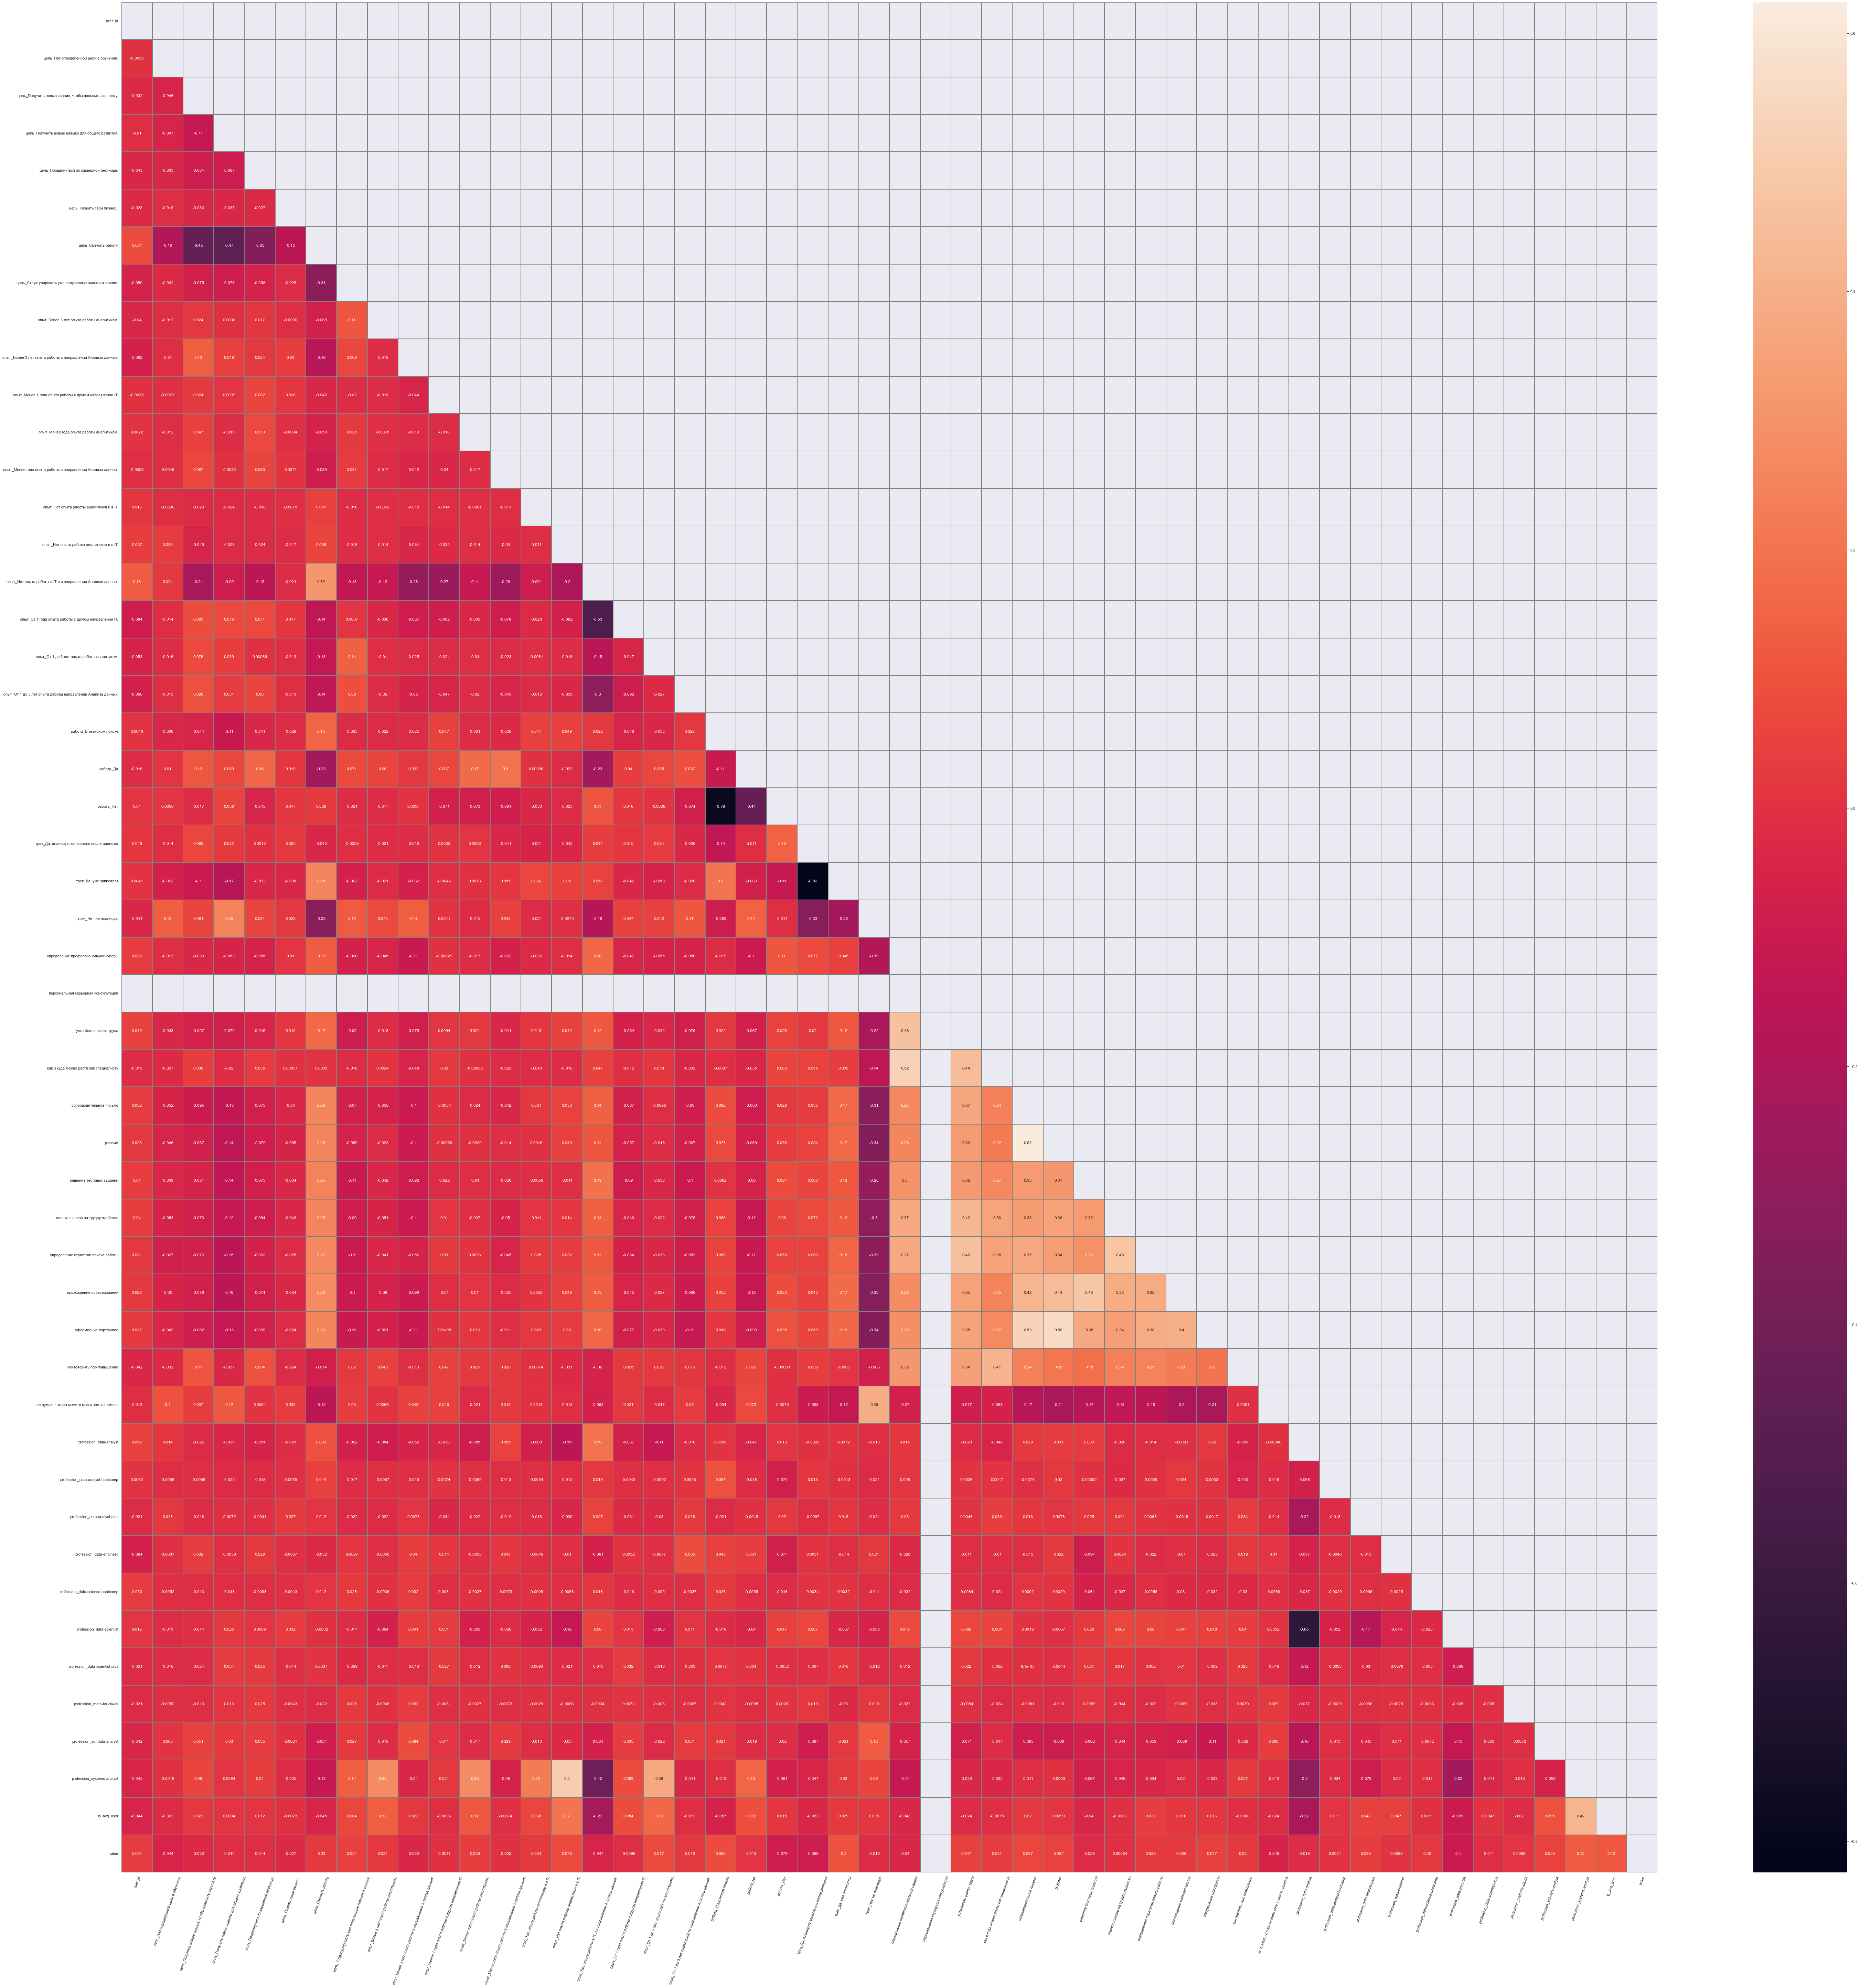

In [89]:
qwerty = final_for_cluster.corr() #вычисляем матрицу корреляций

matrix_new = np.triu(final_for_cluster.corr())

fig = plt.figure(figsize=(100,100))
#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(qwerty, annot=True, mask=matrix_new, linewidths=0.1, linecolor='grey')
plt.xticks(rotation = 70)
plt.show()

В большом количестве признаков легко потеряться, поэтому выведем только те пары признаков, где коэффициент корреляции выше 0.7 (это тесная связь):

In [90]:
only_sign = qwerty.unstack()
only_sign = only_sign[abs(only_sign)>0.7].reset_index()
only_sign=only_sign.sort_values(by=0,ascending=False)
only_sign = only_sign.query('level_0 != level_1')
display(only_sign)

,level_0,level_1,0
20,работа_В активном поиске,работа_Нет,-0.78
22,работа_Нет,работа_В активном поиске,-0.78
25,"трек_Да, планирую записаться после диплома","трек_Да, уже записался",-0.82
26,"трек_Да, уже записался","трек_Да, планирую записаться после диплома",-0.82


Наличие коррелирующих факторов в модели может навредить её качеству. Посмотрим, какой ответ пользователи давали чаще в каждой паре, чтобы понять, какой фактор можно удалить из модели с наименьшим ущербом:

In [91]:
print('В активном поиске ', final_for_cluster['работа_В активном поиске'].sum())
print('Не нашли работу ', final_for_cluster['работа_Нет'].sum())
print('Записался на трек ', final_for_cluster['трек_Да, уже записался'].sum())
print('Планирует записаться на трек ', final_for_cluster['трек_Да, планирую записаться после диплома'].sum())

В активном поиске  573
Не нашли работу  2710
Записался на трек  1292
Планирует записаться на трек  1935


Сначала сформируем модель без удаления признаков. Перед проведением кластеризации построим дендрограмму, чтобы определить оптимальное количество кластеров:

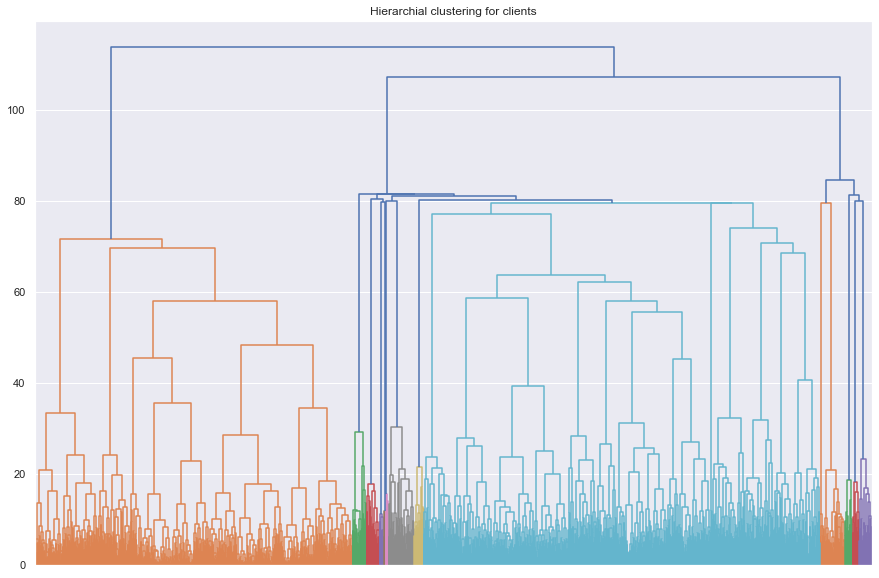

In [92]:
final_for_cluster = final_for_cluster.drop(['user_id', 'profession_name'],axis=1)

# удаляем все Na из-за lp_avg_user и value
final_for_cluster = final_for_cluster.dropna(how='any')

# стандартизируем все данные
scaler_cluster = StandardScaler()
final_for_cluster_st = scaler_cluster.fit_transform(final_for_cluster)

# строим дендрограмму
linked = linkage(final_for_cluster_st, method = 'ward') 

# график дендрограммы
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top', no_labels=True) # уберем ярлыки, чтобы сократить время построения дендрограммы
plt.title('Hierarchial clustering for clients')
plt.show()

По цвету можем увидеть, что выделяется примерно 8-10 кластеров. Такое разбиение и произведём:

In [93]:
# обучаем модель кластеризации на основе К-means
km = KMeans(n_clusters=9, random_state=12345)
labels = km.fit_predict(final_for_cluster_st)

final_for_cluster['cluster_km'] = km.fit_predict(final_for_cluster_st)

# посчитаем средние показатели параметров кластеров

cluster_features = final_for_cluster.groupby('cluster_km').mean().reset_index()
numeric_columns = cluster_features.drop(columns=['cluster_km']).columns
cluster_features.style.format({i: '{:.2f}' for i in numeric_columns}) \
        .highlight_max(color='yellowgreen', subset=numeric_columns) \
        .highlight_min(color='coral', subset=numeric_columns)

,cluster_km,цель_Нет определённой цели в обучении.,"цель_Получить новые знания, чтобы повысить зарплату.",цель_Получить новые навыки для общего развития.,цель_Продвинуться по карьерной лестнице.,цель_Развить свой бизнес.,цель_Сменить работу.,цель_Структурировать уже полученные навыки и знания.,опыт_Более 3 лет опыта работы аналитиком.,опыт_Более 3 лет опыта работы в направлении Анализа данных.,опыт_Менее 1 года опыта работы в другом направлении IT.,опыт_Менее года опыта работы аналитиком.,опыт_Менее года опыта работы в направлении Анализа данных.,опыт_Нет опыта работы аналитиков и в IT.,опыт_Нет опыта работы аналитиком и в IT.,опыт_Нет опыта работы в IT и в направлении Анализа данных.,опыт_От 1 года опыта работы в другом направлении IT.,опыт_От 1 до 3 лет опыта работы аналитиком.,опыт_От 1 до 3 лет опыта работы направлении Анализа данных.,работа_В активном поиске,работа_Да,работа_Нет,"трек_Да, планирую записаться после диплома","трек_Да, уже записался","трек_Нет, не планирую",определение профессиональной сферы,персональная карьерная консультация,устройство рынка труда,как и куда можно расти как специалисту,сопроводительное письмо,резюме,решение тестовых заданий,оценка шансов на трудоустройство,определение стратегии поиска работы,прохождение собеседований,оформление портфолио,как говорить про повышение,"не думаю, что вы можете мне с чем-то помочь",profession_data-analyst,profession_data-analyst-bootcamp,profession_data-analyst-plus,profession_data-engineer,profession_data-science-bootcamp,profession_data-scientist,profession_data-scientist-plus,profession_math-for-da-ds,profession_sql-data-analyst,profession_systems-analyst,lp_avg_user,value
0,0,0.01,0.12,0.13,0.07,0.02,0.59,0.05,0.00,0.06,0.04,0.00,0.03,0.00,0.00,0.64,0.18,0.00,0.06,0.15,0.01,0.81,0.77,0.21,0.00,0.22,0.00,0.17,0.22,0.42,0.54,0.49,0.38,0.38,0.50,0.51,0.13,0.01,0.50,0.01,0.06,0.00,0.01,0.33,0.02,0.00,0.03,0.03,0.69,0.79
1,1,0.00,0.19,0.12,0.08,0.00,0.27,0.35,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.19,0.73,0.46,0.27,0.27,0.23,0.00,0.42,0.50,0.42,0.69,0.50,0.38,0.46,0.46,0.46,0.62,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.89,1.07
2,2,0.02,0.07,0.09,0.03,0.01,0.75,0.02,0.00,0.02,0.04,0.00,0.02,0.00,0.00,0.79,0.11,0.00,0.03,0.11,0.02,0.87,0.98,0.00,0.02,0.77,0.00,0.81,0.77,0.93,0.97,0.91,0.91,0.93,0.95,0.97,0.54,0.04,0.47,0.01,0.06,0.00,0.00,0.42,0.01,0.00,0.01,0.02,0.69,0.77
3,3,0.07,0.17,0.35,0.10,0.04,0.12,0.14,0.00,0.14,0.04,0.00,0.07,0.00,0.00,0.38,0.23,0.01,0.14,0.04,0.16,0.78,0.04,0.00,0.95,0.10,0.00,0.06,0.20,0.11,0.18,0.22,0.11,0.09,0.18,0.14,0.18,0.42,0.48,0.00,0.04,0.00,0.00,0.28,0.01,0.00,0.12,0.07,0.69,0.74
4,4,0.00,0.34,0.13,0.21,0.00,0.16,0.17,0.00,0.05,0.05,0.16,0.13,0.01,0.00,0.03,0.20,0.29,0.07,0.03,0.61,0.36,0.66,0.27,0.07,0.27,0.00,0.38,0.53,0.61,0.76,0.65,0.53,0.57,0.67,0.67,0.54,0.01,0.20,0.00,0.02,0.00,0.00,0.15,0.01,0.00,0.00,0.62,0.81,1.14
5,5,0.05,0.01,0.06,0.02,0.00,0.83,0.02,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.28,0.02,0.70,0.41,0.52,0.07,0.42,0.00,0.63,0.43,0.84,0.89,0.65,0.67,0.75,0.87,0.82,0.25,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.86,1.27
6,6,0.00,0.00,0.20,0.20,0.00,0.40,0.20,0.00,0.20,0.00,0.00,0.00,0.00,0.00,0.60,0.20,0.00,0.00,0.20,0.00,0.80,0.80,0.00,0.20,0.20,0.00,0.40,0.20,0.60,0.60,0.80,0.60,0.40,0.80,0.60,0.40,0.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.64,1.08
7,7,0.00,0.25,0.08,0.17,0.00,0.42,0.08,0.00,0.17,0.08,0.00,0.08,0.00,0.00,0.17,0.17,0.00,0.33,0.42,0.17,0.25,0.58,0.25,0.17,0.25,0.00,0.42,0.42,0.58,0.92,0.00,0.67,0.50,0.67,0.58,0.50,0.08,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.80,0.97
8,8,0.01,0.04,0.03,0.03,0.00,0.87,0.02,0.00,0.02,0.04,0.00,0.03,0.01,0.00,0.76,0.11,0.00,0.03,0.27,0.00,0.72,0.00,1.00,0.00,0.59,0.00,0.68,0.60,0.90,0.95,0.86,0.82,0.86,0.92,0.93,0.40,0.01,0.50,0.00,0.06,0.00,0.00,0.33,0.02,0.00,0.03,0.04,0.70,0.99


Таким образом, мы получили 9 групп пользователей, которые обладают схожими признаками. По графам lp_avg_user и value мы можем делать выводы о качестве полученных студентами этих групп знаний и уровень их уверенности в них.

Средний уровень оценки знаний но основе тестов и квизов имеет минимальное значение в 6-м кластере. Мы можем видеть, что сюда попали студенты программы математики для дата-аналитиков и сайнтистов. Они планируют записаться в карьерный трек после диплома, где в большей степени их интересует решение тестовых заданий и прохождение собеседований. Не нашли работу в период обучения. В большинстве случаев пришли в Практикум с целью сменить работу и не имеют опыта работы в IT или направлении анализа данных.  
Таким образом, резюмируя, можно выдвинуть гипотезу по улучшению
выстраивания помощи студентам в достижении их целей. В программу математики целесообразно внедрить примеры тестовых заданий с последующим их разбором.

Наименьшую среднюю оценку уверенности в знаниях имеют студенты из 3-го кластера. Чаще всего это дата-аналитики или дата-сайнтисты, которые хотят получить новые навыки для общего развития. У них либо нет опыта в IT и анализе данных, либо от года опыта в другом направлении IT. Таких пользователей не интересует карьерный трек. Можно для таких студентов предусмотреть альтернативный вариант помощи. Например, предоставить доступ к дополнительным материалам и литературе и предложить скидку на какие-то смежные программы обучения.

Ну и посмотрим, какую мы получим модель, удалив коррелирующие факторы:

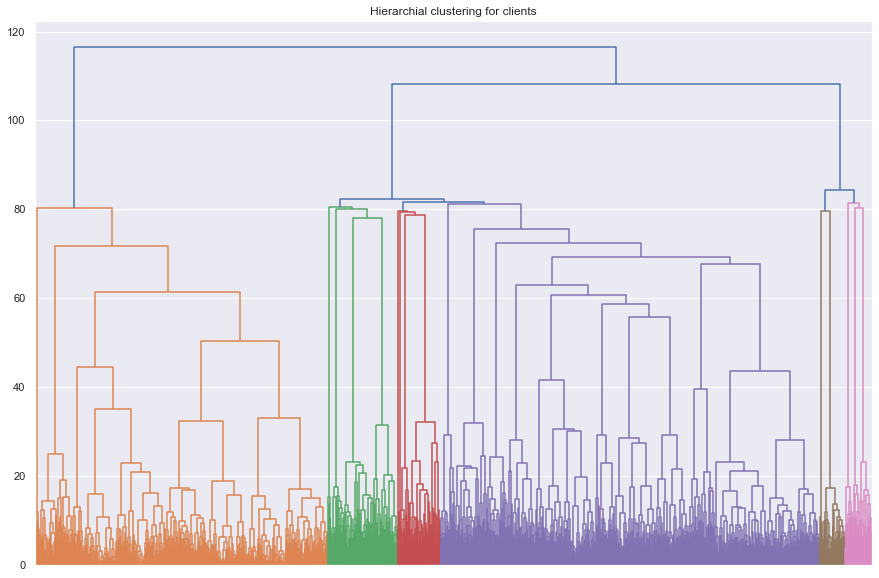

In [94]:
final_for_cluster = final_for_cluster.drop(['работа_В активном поиске', 'трек_Да, уже записался'],axis=1)

# стандартизируем все данные
scaler_cluster = StandardScaler()
final_for_cluster_st = scaler_cluster.fit_transform(final_for_cluster)

# строим дендрограмму
linked = linkage(final_for_cluster_st, method = 'ward') 

# график дендрограммы
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top', no_labels=True) # уберем ярлыки, чтобы сократить время построения дендрограммы
plt.title('Hierarchial clustering for clients')
plt.show()

Здесь четко просматривается 6 кластеров. Таким образом и произведём разбиение:

In [95]:
# обучаем модель кластеризации на основе К-means
km = KMeans(n_clusters=6, random_state=12345)
labels = km.fit_predict(final_for_cluster_st)

final_for_cluster['cluster_km'] = km.fit_predict(final_for_cluster_st)

# посчитаем средние показатели параметров кластеров

cluster_features = final_for_cluster.groupby('cluster_km').mean().reset_index()
numeric_columns = cluster_features.drop(columns=['cluster_km']).columns
cluster_features.style.format({i: '{:.2f}' for i in numeric_columns}) \
        .highlight_max(color='yellowgreen', subset=numeric_columns) \
        .highlight_min(color='coral', subset=numeric_columns)

,cluster_km,цель_Нет определённой цели в обучении.,"цель_Получить новые знания, чтобы повысить зарплату.",цель_Получить новые навыки для общего развития.,цель_Продвинуться по карьерной лестнице.,цель_Развить свой бизнес.,цель_Сменить работу.,цель_Структурировать уже полученные навыки и знания.,опыт_Более 3 лет опыта работы аналитиком.,опыт_Более 3 лет опыта работы в направлении Анализа данных.,опыт_Менее 1 года опыта работы в другом направлении IT.,опыт_Менее года опыта работы аналитиком.,опыт_Менее года опыта работы в направлении Анализа данных.,опыт_Нет опыта работы аналитиков и в IT.,опыт_Нет опыта работы аналитиком и в IT.,опыт_Нет опыта работы в IT и в направлении Анализа данных.,опыт_От 1 года опыта работы в другом направлении IT.,опыт_От 1 до 3 лет опыта работы аналитиком.,опыт_От 1 до 3 лет опыта работы направлении Анализа данных.,работа_Да,работа_Нет,"трек_Да, планирую записаться после диплома","трек_Нет, не планирую",определение профессиональной сферы,персональная карьерная консультация,устройство рынка труда,как и куда можно расти как специалисту,сопроводительное письмо,резюме,решение тестовых заданий,оценка шансов на трудоустройство,определение стратегии поиска работы,прохождение собеседований,оформление портфолио,как говорить про повышение,"не думаю, что вы можете мне с чем-то помочь",profession_data-analyst,profession_data-analyst-bootcamp,profession_data-analyst-plus,profession_data-engineer,profession_data-science-bootcamp,profession_data-scientist,profession_data-scientist-plus,profession_math-for-da-ds,profession_sql-data-analyst,profession_systems-analyst,lp_avg_user,value
0,0,0.02,0.08,0.09,0.03,0.01,0.74,0.03,0.00,0.02,0.04,0.00,0.02,0.00,0.00,0.79,0.10,0.00,0.03,0.04,0.86,0.98,0.01,0.77,0.00,0.81,0.77,0.93,0.97,0.91,0.91,0.93,0.95,0.97,0.55,0.04,0.48,0.01,0.06,0.00,0.00,0.43,0.01,0.00,0.01,0.00,0.69,0.77
1,1,0.07,0.16,0.36,0.11,0.04,0.13,0.14,0.03,0.14,0.04,0.00,0.06,0.00,0.00,0.35,0.21,0.02,0.13,0.17,0.77,0.04,0.95,0.09,0.00,0.06,0.21,0.10,0.17,0.22,0.11,0.08,0.18,0.14,0.19,0.41,0.45,0.00,0.03,0.01,0.00,0.26,0.00,0.00,0.12,0.12,0.71,0.75
2,2,0.01,0.04,0.03,0.03,0.00,0.87,0.02,0.00,0.02,0.04,0.00,0.03,0.00,0.00,0.79,0.09,0.00,0.03,0.01,0.72,0.00,0.00,0.60,0.00,0.68,0.60,0.90,0.95,0.85,0.82,0.86,0.92,0.93,0.40,0.01,0.52,0.00,0.07,0.01,0.00,0.34,0.02,0.00,0.04,0.01,0.70,0.99
3,3,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.06,0.53,0.18,0.00,0.24,0.00,0.59,0.35,0.82,0.76,0.65,0.71,0.82,0.76,0.88,0.35,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.82,1.16
4,4,0.01,0.13,0.13,0.09,0.01,0.57,0.05,0.00,0.06,0.04,0.00,0.05,0.00,0.00,0.63,0.17,0.00,0.07,0.06,0.77,0.77,0.00,0.22,0.00,0.18,0.23,0.42,0.55,0.50,0.38,0.38,0.50,0.51,0.15,0.01,0.52,0.01,0.06,0.01,0.01,0.34,0.02,0.00,0.03,0.00,0.68,0.79
5,5,0.02,0.18,0.09,0.09,0.00,0.48,0.13,0.08,0.02,0.05,0.11,0.00,0.00,0.32,0.01,0.23,0.17,0.02,0.16,0.69,0.56,0.05,0.34,0.00,0.49,0.48,0.73,0.83,0.64,0.62,0.66,0.77,0.74,0.42,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.87,1.24


Наименьшую среднюю оценку знаний имеют пользователи из 4-го кластера. Это дата-аналитики, которые хотят в большинстве случаев хотят сменить работу, не имеют опыта ни в IT, ни в анализе данных. За время обучения не нашли работу и хотят записаться в карьерный трек после диплома, где в наибольшей степени их интересует резюме, решение тестовых заданий, прохождение собеседований и оформление портфолио. Решением для таких студентов может быть предоставление доступа к примерам тестовых заданий или списку идей для собственных pet-проектов.

Наименьшую уверенность в знаниях демонстрируют пользователи из 1-го кластера, который по своим характеристикам очень похож на 3-ий из предыдущей модели. Рекомендации здесь такие же.

<a id='anchor_8'></a>
## Общий вывод по исследованию

Базой для текущего анализа послужили данные об ответах пользователей на вопросы об их целях и ожидниях от курса а также данные об оценках знаний, уверенности студентов в новых знаниях и вероятности рекомендации Практикума. В процессе исследования необходимо было составить портреты пользователей, сегментировать их и определить проблемные места, сформулировать гипотезы по улучшению
выстраивания помощи студентам в достижении их целей.

Наиболее многочисленными являются программы дата-аналитиков и дата-сайнтистов (38% и 30% соответственно). Главной целью студентов Практикума в большинстве случаев является смена работы (65.4% пользователей). Почти 68% пользователей Практикума с большой вероятностью стали бы рекомендовать текущую программу обучения. Однако, следует отметить, пользователи курсов системных аналитиков, дата-инженеров и SQL для аналитиков и сайнтистов чаще других обращаются к Практикуму не с целью поиска работы.  
Самые популярные из других целей:
- у системных аналитиков: получить новые знания, чтобы повысить зарплату, получить новые знания для общего развития и продвинуться по карьерной лестнице;
- у дата-инженеров: получить новые знания, чтобы повысить зарплату и продвинуться по карьерной лестнице;
- SQL для аналитиков и сайнтистов: получить новые знания, чтобы повысить зарплату, получить новые знания для общего развития.

Таким образом, в данных направлениях обучения в карьерном треке актуально развивать темы повышения зарплаты и карьерного роста.

Программы дата-инженеров и  математики для аналитиков и сайнтистов требуют доработки - студенты данных программ чаще демонстрируют низкую оценку знаний и недостаточную уверенность в новых знаниях. Чаще других не стали бы рекомендовать Практикум. Так, например, 20.7% студентов курса дата-инженеров оценили вероятность рекомендации практикума в размере менее 7 баллов по шкале от 0 до 10, а 12.7% студентов этого курса отметили, что их мнение ухудшилось в течение обучения. Вероятно, стоит посмотреть аналогичные программы конкурентов и попробовать найти пути совершенствования курса. Можно изучить требования к кандидатам в данной профессии, которые требуются на рынке, произвести сравнение с текущей программой и совершенствовать её. Кроме того, студенты из программы дата инженеров чаще других не ощущают уверенность в приобретённых знаниях. Можно предложить добавить опросник в этой программе о том, что именно не до конца поняли студенты, и соответственно дорабатывать эти блоки обучения. Было также установлено, что доработки требуют программа математики для аналитиков/сайнтистов - практически половина (49.9%) пользователей имеют неудовлетворительную оценку знаний. Следует изучить все тесты, предложенные студентам, определить те, что вызывают больше всего трудностей, пересмотреть подачу соответствующего материала в курсе. Возможно, нужно добавить больше примеров или задач на закрепление материала.

Студенты Практикума чаще всего не имеют опыта ни в IT, ни в анализе данных. Они заинтересованы в карьерном треке, а в особенности в резюме, сопроводительном письме, портфолио, тестовых заданиях и прохождении собеседований. Из рекомендаций по улучшению выстраивания помощи студентам можно отметить внедрение в некоторых программах примеров тестовых заданий с последующим их разбором, формирование списка идей для pet-проектов. Для пользователей, которых не интересует карьерный трек и которые пришли за новыми знаниями, можно предоставить доступ к дополнительным материалам и литературе, предложить скидку на какие-то смежные программы обучения.

**Визуальные материалы по исследованию**

Для передачи дизайнерам все основные тезисы, выводы и изображения по исследованию были оформлены в виде презентации, которую можно найти по ссылке ниже:

[Презентация](https://drive.google.com/file/d/1M4zUeAtOjtWh0V0hxMwj-H3mWtUQVSrl/view?usp=sharing) подготовленная в формате pdf. 
